### IMPORTING ALL REQUIRED LIBRARIES

In [42]:
# REQUIRED IMPORTS 
import numpy as np
import pandas as pd
from pathlib import Path
# Update the deprecated functions to the new ones:
from tensorflow.compat.v1.losses import sparse_softmax_cross_entropy
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import os
import math
import torch
import tensorflow as tf

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import NMF
from rdkit import Chem
from torch_geometric.data import Data
from collections import OrderedDict
from rdkit import Chem
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from torch_geometric.data import DataLoader
# Update the deprecated functions to the new ones:
from tensorflow.compat.v1.losses import sparse_softmax_cross_entropy
#from mol2graph import mol2torchdata            # Use absolute import instead of relative import
#import models as molan_model

import gpflow
import pickle
## Setting up the path prefix

##path_prefix = ''



##### Calling MODULES USED
* Mol2Graph.py 
* Preprocessing
* Dataset 
* Helpers
* Experimental_setup.py 
* Training.py
* Models.py 
* Config.py



In [43]:
### Mol2Graph.py ---> original 
from rdkit import Chem
import numpy as np
import torch
from torch_geometric.data import Data


possible_atom_list = ['S', 'Si', 'F', 'O',
                      'C', 'I', 'P', 'Cl', 'Br', 'N', 'Unknown']
possible_numH_list = [0, 1, 2, 3, 4]
possible_valence_list = [0, 1, 2, 3, 4, 5, 6]
possible_formal_charge_list = [-3, -2, -1, 0, 1, 2, 3]
possible_hybridization_list = [
    Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2
]
possible_number_radical_e_list = [0, 1, 2]
possible_chirality_list = ['R', 'S']

reference_lists = [
    possible_atom_list, possible_numH_list, possible_valence_list,
    possible_formal_charge_list, possible_number_radical_e_list,
    possible_hybridization_list, possible_chirality_list
]


def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


def safe_index(l, e):
    """Gets the index of e in l, providing an index of len(l) if not found"""
    try:
        return l.index(e)
    except:
        return len(l)


def get_feature_list(atom):
    features = 6 * [0]
    features[0] = safe_index(possible_atom_list, atom.GetSymbol())
    features[1] = safe_index(possible_numH_list, atom.GetTotalNumHs())
    features[2] = safe_index(possible_valence_list, atom.GetImplicitValence())
    features[3] = safe_index(
        possible_formal_charge_list, atom.GetFormalCharge())
    features[4] = safe_index(possible_number_radical_e_list,
                             atom.GetNumRadicalElectrons())
    features[5] = safe_index(
        possible_hybridization_list, atom.GetHybridization())
    return features


def atom_features(atom):

    results = one_of_k_encoding_unk(atom.GetSymbol(), possible_atom_list) + \
        one_of_k_encoding(atom.GetDegree(),
                          [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) + \
        one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]) + \
        [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
        one_of_k_encoding_unk(atom.GetHybridization(), [
            Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
            Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.
            SP3D, Chem.rdchem.HybridizationType.SP3D2
        ]) + [atom.GetIsAromatic()]
    return np.array(results).astype(np.float32)


def bond_features(bond):
    bt = bond.GetBondType()
    bond_feats = [
        bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),
        bond.IsInRing()]
    return np.array(bond_feats).astype(np.float32)


def get_bond_pair(mol):
    bonds = mol.GetBonds()
    res = [[], []]
    for bond in bonds:
        res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
    return res


def mol2torchdata(mol):
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()
    node_f = [atom_features(atom) for atom in atoms]
    edge_index = get_bond_pair(mol)
    edge_attr = [bond_features(bond) for bond in bonds]
    for bond in bonds:
        edge_attr.append(bond_features(bond))
    data = Data(x=torch.tensor(node_f, dtype=torch.float),
                edge_index=torch.tensor(edge_index, dtype=torch.long),
                edge_attr=torch.tensor(edge_attr, dtype=torch.float)
                )
    return data


def n_atom_features():
    atom = Chem.MolFromSmiles('C').GetAtomWithIdx(0)
    return len(atom_features(atom))


def n_bond_features():
    bond = Chem.MolFromSmiles('CC').GetBondWithIdx(0)
    return len(bond_features(bond))


In [44]:
### Load Config.py -----> original 

from collections import OrderedDict
import random


def random_hparams():
    hparams = OrderedDict()
    hparams['mlp_layers'] = random.randint(0, 6)  # 5
    hparams['mlp_base_dim'] = random.randint(25, 151)  # [25,150]
    hparams['mlp_dim_ratio'] = random.uniform(0.5, 1.50)
    hparams['mlp_dropout'] = random.uniform(0.0, 0.5)
    hparams['mlp_act'] = random.choice(['relu', 'selu', 'celu', 'softplus'])
    hparams['mlp_batchnorm'] = random.choice([True, False])
    hparams['emb_steps'] = random.randint(2, 7)
    hparams['atom_dim'] = random.randint(32, 251)
    hparams['residual'] = random.choice([True, False])
    hparams['conv_act'] = random.choice(['relu', 'selu', 'celu', 'softplus'])
    hparams['conv_dim'] = random.randint(25, 251)
    hparams['conv_aggr'] = 'add'
    hparams['conv_n'] = random.randint(3, 9)
    return hparams

In [45]:
### Helpers.py ----> original 

from rdkit import Chem
from rdkit.Chem import AllChem

def create_morgan_space(r = 2, nbits = 128):
    def model(mol):
        return Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius = r, nBits = nbits)
    return model

def count_cf_bonds(mol):
    abstract_cf = Chem.MolFromSmarts('C~F')
    
    cf_bonds = mol.GetSubstructMatches(abstract_cf)
    return len(cf_bonds)

#@source https://github.com/keras-team/keras/issues/341#issuecomment-539198392
def init_layer(layer):
    #where are the initializers?
    if hasattr(layer, 'cell'):
        init_container = layer.cell
    else:
        init_container = layer

    for key, initializer in init_container.__dict__.items():
        if "initializer" not in key: #is this item an initializer?
                continue #if no, skip it

        # find the corresponding variable, like the kernel or the bias
        if key == 'recurrent_initializer': #special case check
            var = getattr(init_container, 'recurrent_kernel')
        else:
            var = getattr(init_container, key.replace("_initializer", ""))

        var.assign(initializer(var.shape, var.dtype))
        #use the initializer

[23:02:19] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[23:02:28] Explicit valence for atom # 1 Cl, 3, is greater than permitted


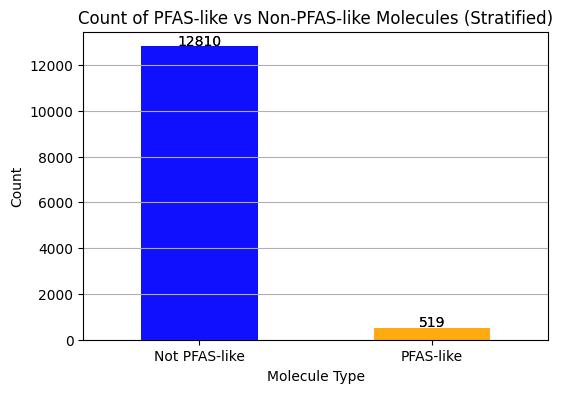

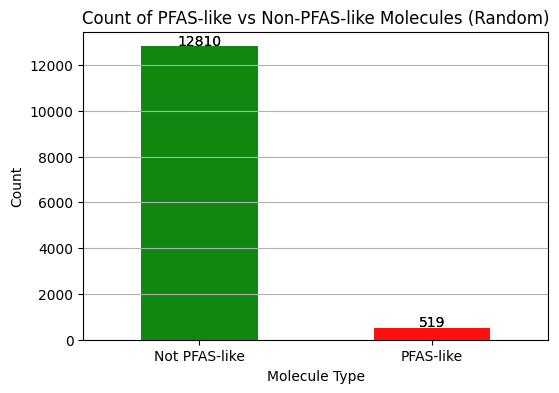

In [47]:
### Preprocessing of datasets.
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold

from rdkit import Chem
from rdkit.Chem import Descriptors


#from helpers import count_cf_bonds, create_morgan_space
#from graphnn import mol2graph
def pad_array(array, max_shape):
    pad_width = [(0, max_size - arr_size) for arr_size, max_size in zip(array.shape, max_shape)]
    return np.pad(array, pad_width, mode='constant', constant_values=0)

# Apply padding to each array in the list

def generate_dataset(splitter, name):
    ldtoxdb = pd.read_csv('../data/ldtoxdb-mordred.csv').dropna(axis=1)

    ldtoxdb['rd_mol'] = ldtoxdb.SMI.apply(Chem.MolFromSmiles)
    ldtoxdb['n_cf_bonds'] = ldtoxdb.rd_mol.apply(count_cf_bonds)
    ldtoxdb['mol_wt'] = ldtoxdb.rd_mol.apply(Chem.Descriptors.MolWt)
    ldtoxdb['is_pfas_like'] = ldtoxdb['n_cf_bonds'] >= 2

    pfas8k = pd.read_csv('../data/pfas8k-mordred.csv')
    
    pfas8k['mol'] = pfas8k.SMILES.apply(Chem.MolFromSmiles)
    pfas8k = pfas8k[pfas8k['mol'].notnull()]  
    
    
    #DU -- Getting rid of None values before converting them to SMILES   
    # Remove rows where the molecule is None
    # DU-- No need for this line 
    # pfas8k['canon_smi'] = pfas8k.SMILES.apply(Chem.MolFromSmiles).apply(Chem.MolToSmiles)
    pfas8k['canon_smi'] = pfas8k['mol'].apply(Chem.MolToSmiles)
    ldtoxdb['is_pfas'] = ldtoxdb.SMI.isin(pfas8k.canon_smi)
    mordred = ldtoxdb.columns[5:-5]
    
    
    
    # comment next 4 lines for speed if processing data only for non-benchmarks
   # ecfp4096 = np.array(ldtoxdb.rd_mol.apply(create_morgan_space(nbits=4096, r=2)).tolist())
    #ecfp2048 = np.array(ldtoxdb.rd_mol.apply(create_morgan_space(nbits=2048, r=1)).tolist())
    #ecfp2048r6 = np.array(ldtoxdb.rd_mol.apply(create_morgan_space(nbits=2048, r=6)).tolist())
    
    ## DU getting graph arrays to be the same length 
   #graph = [mol2torchdata(mol) for mol in ldtoxdb.rd_mol]
   #graph = np.array(ldtoxdb.rd_mol.apply(mol2torchdata).tolist())
   # max_shape = np.max([arr.shape for arr in graph], axis=0)
   # padded_graph = [pad_array(arr, max_shape) for arr in graph]
   # graph = np.array(padded_graph)

    # for stratified splitting
    bins = pd.cut(ldtoxdb[['NeglogLD50']].to_numpy().reshape(-1), bins=5, labels=False)

    for foldno, (train_idx, test_idx) in enumerate(splitter.split(ldtoxdb, bins)):
        prefix = '../data/preprocessed/%s/fold%d' % (name, foldno)

        train = ldtoxdb.iloc[train_idx]
        test = ldtoxdb.iloc[test_idx]

        pfas_like_pfas_excluded_train = train.loc[(train.is_pfas_like & ~train.is_pfas)]
        pfas_like_pfas_excluded_test = test.loc[(test.is_pfas_like & ~test.is_pfas)]
        pfas_like_train = train.loc[train.is_pfas_like]
        pfas_like_test = test.loc[test.is_pfas_like]
        pfas_like_excluded_train = train.loc[~train.is_pfas_like]
        pfas_like_excluded_test = test.loc[~test.is_pfas_like]
        pfas_excluded_train = train.loc[~train.is_pfas]
        pfas_excluded_test = test.loc[~test.is_pfas]
        pfas_train = train.loc[train.is_pfas]
        pfas_test = test.loc[test.is_pfas]

        pfas_like_train_idx = pfas_like_train.index
        pfas_like_test_idx = pfas_like_test.index

        # SMILES
        np.savez_compressed(prefix + '_smiles_test', smiles=test[['SMI']].to_numpy())
        np.savez_compressed(prefix + '_smiles_train', smiles=train[['SMI']].to_numpy())

        np.savez_compressed(prefix + '_smiles_test_pfas_like', smiles=pfas_like_test[['SMI']].to_numpy())
        np.savez_compressed(prefix + '_smiles_train_pfas_like', smiles=pfas_like_train[['SMI']].to_numpy())

        np.savez_compressed(prefix + '_smiles_test_pfas_like_excluded', smiles=pfas_like_excluded_test[['SMI']].to_numpy())
        np.savez_compressed(prefix + '_smiles_train_pfas_like_excluded', smiles=pfas_like_excluded_train[['SMI']].to_numpy())

        np.savez_compressed(prefix + '_smiles_test_pfas_like_pfas_excluded', smiles=pfas_like_pfas_excluded_test[['SMI']].to_numpy())
        np.savez_compressed(prefix + '_smiles_train_pfas_like_pfas_excluded', smiles=pfas_like_pfas_excluded_train[['SMI']].to_numpy())

        np.savez_compressed(prefix + '_smiles_test_pfas_excluded', smiles=pfas_excluded_test[['SMI']].to_numpy())
        np.savez_compressed(prefix + '_smiles_train_pfas_excluded', smiles=pfas_excluded_train[['SMI']].to_numpy())

        np.savez_compressed(prefix + '_smiles_test_pfas', smiles=pfas_test[['SMI']].to_numpy())
        np.savez_compressed(prefix + '_smiles_train_pfas', smiles=pfas_train[['SMI']].to_numpy())

        # Outputs
        np.savez_compressed(prefix + '_y_test', y=test[['NeglogLD50']].to_numpy())
        np.savez_compressed(prefix + '_y_train', y=train[['NeglogLD50']].to_numpy())

        np.savez_compressed(prefix + '_y_test_pfas_like', y=pfas_like_test[['NeglogLD50']].to_numpy())
        np.savez_compressed(prefix + '_y_train_pfas_like', y=pfas_like_train[['NeglogLD50']].to_numpy())

        np.savez_compressed(prefix + '_y_test_pfas_like_excluded', y=pfas_like_excluded_test[['NeglogLD50']].to_numpy())
        np.savez_compressed(prefix + '_y_train_pfas_like_excluded', y=pfas_like_excluded_train[['NeglogLD50']].to_numpy())

        np.savez_compressed(prefix + '_y_test_pfas_like_pfas_excluded', y=pfas_like_pfas_excluded_test[['NeglogLD50']].to_numpy())
        np.savez_compressed(prefix + '_y_train_pfas_like_pfas_excluded', y=pfas_like_pfas_excluded_train[['NeglogLD50']].to_numpy())

        np.savez_compressed(prefix + '_y_test_pfas_excluded', y=pfas_excluded_test[['NeglogLD50']].to_numpy())
        np.savez_compressed(prefix + '_y_train_pfas_excluded', y=pfas_excluded_train[['NeglogLD50']].to_numpy())

        np.savez_compressed(prefix + '_y_test_pfas', y=pfas_test[['NeglogLD50']].to_numpy())
        np.savez_compressed(prefix + '_y_train_pfas', y=pfas_train[['NeglogLD50']].to_numpy())

        # Mordred inputs
        col_selector = VarianceThreshold()
        np.savez_compressed(prefix + '_mordred_x_train', x=col_selector.fit_transform(train[mordred]).astype(np.float32))
        np.savez_compressed(prefix + '_mordred_x_test', x=col_selector.transform(test[mordred]).astype(np.float32))

        np.savez_compressed(prefix + '_mordred_x_train_pfas_like', x=col_selector.transform(pfas_like_train[mordred]).astype(np.float32))
        np.savez_compressed(prefix + '_mordred_x_test_pfas_like', x=col_selector.transform(pfas_like_test[mordred]).astype(np.float32))

        np.savez_compressed(prefix + '_mordred_x_train_pfas_like_excluded', x=col_selector.transform(pfas_like_excluded_train[mordred]).astype(np.float32))
        np.savez_compressed(prefix + '_mordred_x_test_pfas_like_excluded', x=col_selector.transform(pfas_like_excluded_test[mordred]).astype(np.float32))

        np.savez_compressed(prefix + '_mordred_x_train_pfas_like_pfas_excluded', x=col_selector.transform(pfas_like_pfas_excluded_train[mordred]).astype(np.float32))
        np.savez_compressed(prefix + '_mordred_x_test_pfas_like_pfas_excluded', x=col_selector.transform(pfas_like_pfas_excluded_test[mordred]).astype(np.float32))

        np.savez_compressed(prefix + '_mordred_x_train_pfas_excluded', x=col_selector.transform(pfas_excluded_train[mordred]).astype(np.float32))
        np.savez_compressed(prefix + '_mordred_x_test_pfas_excluded', x=col_selector.transform(pfas_excluded_test[mordred]).astype(np.float32))

        np.savez_compressed(prefix + '_mordred_x_train_pfas', x=col_selector.transform(pfas_train[mordred]).astype(np.float32))
        np.savez_compressed(prefix + '_mordred_x_test_pfas', x=col_selector.transform(pfas_test[mordred]).astype(np.float32))

        # We need these for inference later on
        indices = col_selector.get_support(indices=True)
        np.savez_compressed(prefix + '_mordred_x_cols', cols=train[mordred].iloc[[0], indices].columns)

        return ldtoxdb
        continue

        # ECFP-4096 inputs
        np.savez_compressed(prefix + '_ecfp_4096_x_train', x=col_selector.fit_transform(ecfp4096[train_idx]).astype(np.float32))
        np.savez_compressed(prefix + '_ecfp_4096_x_test', x=col_selector.transform(ecfp4096[test_idx]).astype(np.float32))

        np.savez_compressed(prefix + '_ecfp_4096_x_train_pfas_like', x=col_selector.transform(ecfp4096[pfas_like_train_idx]).astype(np.float32))
        np.savez_compressed(prefix + '_ecfp_4096_x_test_pfas_like', x=col_selector.transform(ecfp4096[pfas_like_test_idx]).astype(np.float32))

        # ECFP-2048 inputs
        np.savez_compressed(prefix + '_ecfp_2048_x_train', x=col_selector.fit_transform(ecfp2048[train_idx]).astype(np.float32))
        np.savez_compressed(prefix + '_ecfp_2048_x_test', x=col_selector.transform(ecfp2048[test_idx]).astype(np.float32))

        np.savez_compressed(prefix + '_ecfp_2048_x_train_pfas_like', x=col_selector.transform(ecfp2048[pfas_like_train_idx]).astype(np.float32))
        np.savez_compressed(prefix + '_ecfp_2048_x_test_pfas_like', x=col_selector.transform(ecfp2048[pfas_like_test_idx]).astype(np.float32))

        # ECFP-2048 inputs
        np.savez_compressed(prefix + '_ecfp_2048r6_x_train', x=col_selector.fit_transform(ecfp2048r6[train_idx]).astype(np.float32))
        np.savez_compressed(prefix + '_ecfp_2048r6_x_test', x=col_selector.transform(ecfp2048r6[test_idx]).astype(np.float32))

        np.savez_compressed(prefix + '_ecfp_2048r6_x_train_pfas_like', x=col_selector.transform(ecfp2048r6[pfas_like_train_idx]).astype(np.float32))
        np.savez_compressed(prefix + '_ecfp_2048r6_x_test_pfas_like', x=col_selector.transform(ecfp2048r6[pfas_like_test_idx]).astype(np.float32))

        # GP Convienience
        col_selector2 = VarianceThreshold()
        np.savez_compressed(prefix + '_gp_x_train', x=col_selector.fit_transform(train[mordred]).astype(np.float32),
                                                            x2=col_selector2.fit_transform(ecfp4096[train_idx]).astype(np.float32))
        np.savez_compressed(prefix + '_gp_x_test', x=col_selector.transform(test[mordred]).astype(np.float32),
                                                           x2=col_selector2.transform(ecfp4096[test_idx]).astype(np.float32))
        

def main():
    np.random.seed(9700)
    ldtoxdb_strat = generate_dataset(splitter=KFold(n_splits=5, shuffle=True), name='random')

    np.random.seed(9700)
    ldtoxdb_rand= generate_dataset(splitter=StratifiedKFold(n_splits=5, shuffle=True), name='stratified')
    return ldtoxdb_strat, ldtoxdb_rand

##DU adding a visualisation component 
def visualize_datasets(ldtoxdb_strat, ldtoxdb_rand):
    import matplotlib.pyplot as plt

    # Count the number of entries where 'is_pfas_like' is True for both datasets
    pfas_like_count_strat = ldtoxdb_strat['is_pfas_like'].value_counts()
    pfas_like_count_rand = ldtoxdb_rand['is_pfas_like'].value_counts()

    # Plotting the result for stratified data
    plt.figure(figsize=(6, 4))
    pfas_like_count_strat.plot(kind='bar', color=['blue', 'orange'], alpha=0.75)
    plt.title('Count of PFAS-like vs Non-PFAS-like Molecules (Stratified)')
    plt.xticks([0, 1], ['Not PFAS-like', 'PFAS-like'], rotation=0)
    ax = pfas_like_count_strat.plot(kind='bar', color=['blue', 'orange'], alpha=0.75)
    plt.ylabel('Count')
    plt.xlabel('Molecule Type')
    plt.grid(axis='y')
    ax.set_xticklabels(['Not PFAS-like', 'PFAS-like'], rotation=0)

    for i in ax.patches:
        ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 50,  # Adjust +50 for space above the bar
                str(int(i.get_height())), ha='center', fontsize=10)

    plt.show()

    # Plotting the result for random data
    plt.figure(figsize=(6, 4))
    pfas_like_count_rand.plot(kind='bar', color=['green', 'red'], alpha=0.75)
    plt.title('Count of PFAS-like vs Non-PFAS-like Molecules (Random)')
    plt.xticks([0, 1], ['Not PFAS-like', 'PFAS-like'], rotation=0)
    ax2 = pfas_like_count_rand.plot(kind='bar', color=['green', 'red'], alpha=0.75)
    plt.ylabel('Count')
    plt.xlabel('Molecule Type')
    plt.grid(axis='y')
    ax2.set_xticklabels(['Not PFAS-like', 'PFAS-like'], rotation=0)

    for i in ax2.patches:
        ax2.text(i.get_x() + i.get_width() / 2, i.get_height() + 50,  # Adjust +50 for space above the bar
                 str(int(i.get_height())), ha='center', fontsize=10)
    
    plt.show()
#if __name__ == '__main__':
###    main()

if __name__ == '__main__':
    ldtoxdb_strat, ldtoxdb_rand = main()  # Call main to get the datasets
    visualize_datasets(ldtoxdb_strat, ldtoxdb_rand)  # Visualize the results


In [48]:
### Dataset.py ---> original 
import numpy as np
from pathlib import Path
import os

def load_dataset(encoding, fold, stratified, subset, path_prefix=''):

    base_path = os.getcwd() + path_prefix + '/../data/preprocessed/{type}/fold{no}_'.format(
        type = 'random' if not stratified else 'stratified',
        no = fold
    )

    x_paths = base_path + '{encoding}' + '_{set}{subset}.npz'
    y_paths = base_path + '{set}{subset}.npz'

    subset = ('_' + subset) if subset is not None else ''

    y_train = y_paths.format(set = 'y_train', subset = subset)
    smiles_train = y_paths.format(set = 'smiles_train', subset = subset)

    x_train = x_paths.format(encoding=encoding, set = 'x_train', subset = subset)

    if encoding == 'smiles':
        x_train = smiles_train

    x_train_load = np.load(x_train, allow_pickle=True)
    x_train_load = [x_train_load[f] for f in x_train_load.files]

    if len(x_train_load) == 1:
        x_train_load = x_train_load[0]


    y_test = y_paths.format(set = 'y_test', subset = subset)
    smiles_test = y_paths.format(set = 'smiles_test', subset = subset)

    x_test = x_paths.format(encoding=encoding, set = 'x_test', subset = subset)
    
    if encoding == 'smiles':
        x_test = smiles_test
        
    x_test_load = np.load(x_test, allow_pickle=True)
    x_test_load = [x_test_load[f] for f in x_test_load.files]

    if len(x_test_load) == 1:
        x_test_load = x_test_load[0]

    train = (x_train_load, np.load(y_train, allow_pickle=True)['y'], np.load(smiles_train, allow_pickle=True)['smiles'])
    test = (x_test_load, np.load(y_test, allow_pickle=True)['y'], np.load(smiles_test, allow_pickle=True)['smiles'])

    return (train, test)

In [49]:
### Models.py -----> Original definition  
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import gpflow
import pickle

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import NMF

#from .graphnn import models as molan_model
#from .graphnn import training
#from .graphnn import mol2graph

import torch
from torch_geometric.data import DataLoader

from collections import OrderedDict

from rdkit import Chem

class DNN(keras.Model):
    _n_layers = 1
    _layer_size = 16
    batch_size = 32
    learning_rate = 0.0001
    epochs = 500
    seed = 9700

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.generate_fcn()

    def generate_fcn(self):
        self.pipeline = []

        for i, layer in enumerate(range(self.n_layers)):
            self.pipeline.append(layers.BatchNormalization())
            self.pipeline.append(layers.Dense(self.layer_size, activation='relu'))
        
        self.pipeline.append(layers.BatchNormalization())
        self.pipeline.append(layers.Dense(1, activation='linear'))


    @property
    def n_layers(self):
        return self._n_layers

    @n_layers.setter
    def n_layers(self, value):
        self._n_layers = value
        self.generate_fcn()

    @property
    def layer_size(self):
        return self._layer_size

    @layer_size.setter
    def layer_size(self, value):
        self._layer_size = value
        self.generate_fcn()

    def call(self, inputs):
        x = inputs

        for layer in self.pipeline:
            x = layer(x)
            
        return x

    def fit(self, x_train, y_train, **kwargs):
        tf.random.set_seed(self.seed)

        adam = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

        super().build(input_shape=x_train.shape)
        super().compile(optimizer=adam, loss='mse', metrics=['mse', 'mae'])
        super().fit(x_train, y_train, epochs=self.epochs, batch_size=self.batch_size, **kwargs)

class DNN_Mordred(DNN):
    _n_layers = 4
    _layer_size = 256
    batch_size = 256
    learning_rate = 0.01
    epochs = 10#00

class DNN_ECFP(DNN):
    _n_layers = 1
    _layer_size = 2048
    batch_size = 512
    learning_rate = 0.001
    epochs = 10 #00

class RF:
    seed = 9700
    n_estimators = 4096
    max_depth = 32
    min_samples_split = 2
    min_samples_leaf = 1

    def fit(self, x_train, y_train):
        np.random.seed(self.seed)

        self.estimator = RandomForestRegressor(n_estimators = self.n_estimators,
                                                max_depth = self.max_depth,
                                                min_samples_split = self.min_samples_split,
                                                min_samples_leaf = self.min_samples_leaf, 
                                                n_jobs=-1)

        self.estimator.fit(x_train, y_train.ravel())

        return self

    def predict(self, x):
        if self.estimator is None:
            raise NotImplementedError()

        return self.estimator.predict(x).reshape(-1,1)
    
    def save_weights(self, fn):
        with open(fn, 'wb') as file:
            pickle.dump(self.estimator, file)

    def load_weights(self, fn):
        with open(fn, 'rb') as file:
            self.estimator = pickle.load(file)

class RF_NMF_ECFP(RF):
    def fit(self, x_train, y_train, seed=9700):
        self.estimator = make_pipeline(
            NMF(n_components=12, solver='mu', init='random', max_iter=500, random_state=0, alpha=.1, l1_ratio=.5),
            RandomForestRegressor(min_samples_split=self.min_samples_split,
                                    min_samples_leaf=self.min_samples_leaf,
                                    max_depth = self.max_depth,
                                    n_estimators=self.n_estimators,
                                    n_jobs=-1)
        )

        self.estimator.fit(x_train, y_train.ravel())

        return self


class GP:
    def fit(self, x_train, y_train):
        kernels = []
        i = 0

        for no, (x, reducer, k) in enumerate(zip(x_train,
                                self.rf_feature_selectors,
                                self.rf_feature_reduce_to)):

            indices = (-reducer.estimator.feature_importances_).argsort()[:k]
            x_train[no] = x[:,indices]
            kernels.append(gpflow.kernels.RBF(active_dims=i+np.arange(k)))

            i += k

        x_train = np.hstack(x_train)
        kernel = gpflow.kernels.Sum(kernels)

        self.model = gpflow.models.GPR(data=(x_train.astype(np.float64), y_train.astype(np.float64)), kernel=kernel,
                                        mean_function=None)

        opt = gpflow.optimizers.Scipy()
        opt.minimize(lambda: -self.model.log_marginal_likelihood(), self.model.trainable_variables,
            options={'maxiter': 500})

    def predict(self, x_in):
        for no, (x, reducer, k) in enumerate(zip(x_in,
                                self.rf_feature_selectors,
                                self.rf_feature_reduce_to)):

            indices = (-reducer.estimator.feature_importances_).argsort()[:k]
            x_in[no] = x[:,indices]

        x = np.hstack(x_in)
        return self.model.predict_y(x.astype(np.float64))[0]

    def save_weights(self, fn):
        checkpoint = tf.train.Checkpoint(a=self.model)
        manager = tf.train.CheckpointManager(checkpoint, fn, max_to_keep=9999)
        
        manager.save()

class SN_Mordred:
    batch_size = 256
    learning_rate = 0.004663515283240011
    epochs = 1000
    seed = 9700

    def __init__(self, input_shape=None):
        tf.random.set_seed(self.seed)
        np.random.seed(self.seed)

        x = layers.Input(shape=input_shape)

        body = layers.BatchNormalization()(x)
        body = layers.Dense(128, activation='relu')(body)
        body = layers.BatchNormalization()(body)
        body = layers.Dense(128, activation='relu')(body)
        body = layers.BatchNormalization()(body)
        body = layers.Dense(128, activation='relu')(body)
        body = layers.BatchNormalization()(body)

        prediction = layers.Dense(1, activation='linear', name='prediction')(body)

        selection = layers.Dense(16, activation='relu')(body)
        selection = layers.BatchNormalization()(selection)
        selection = layers.Dense(1, activation='sigmoid', name='selection')(selection)

        selection_out = layers.Concatenate(axis=1, name='selection_head')([prediction, selection])
        auxiliary_out = layers.Dense(1, activation='linear', name='auxiliary_head')(body)

        self.model = tf.keras.models.Model(inputs=x, outputs=[selection_out, auxiliary_out, body])

    def fit(self, x_train, y_train, **kwargs):
        tf.random.set_seed(self.seed)
        np.random.seed(self.seed)

        adam = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

        def coverage(y_true, y_pred):
            return K.mean(K.round(y_pred[:,1]))
        
        def empirical_risk(y_true, y_pred):
            loss = (y_true[:,0] - y_pred[:,0])**2

            mse = K.mean(loss * y_pred[:,1])
            
            emp_risk_num = mse
            emp_risk_denom = K.mean(y_pred[:,1]) #K.mean(K.round(y_pred[:,1]))
            
            return emp_risk_num / emp_risk_denom

        def selective_loss(y_true, y_pred):
            emp_risk = empirical_risk(y_true, y_pred)
            cov = K.mean(y_pred[:,1])
            
            lamda = 32 #converge later
            loss = emp_risk + (lamda * K.maximum(self.c_coverage-cov,0)**2)

            return loss

        self.model.compile(optimizer=adam, loss=[selective_loss, 'mse'], loss_weights=[0.5, 0.5],
            metrics={'selection_head': [selective_loss, empirical_risk, coverage]})
        self.model.fit(x_train, y_train, epochs=self.epochs, batch_size=self.batch_size, **kwargs)

    def predict(self, *args):
        return self.model.predict(*args)

    def save_weights(self, fn):
        return self.model.save_weights(fn)

    def load_weights(self, fn):
        return self.model.load_weights(fn)

class GCN:
    # Some code here taken directly from MOLAN
    seed = 9700
    conv_n_layers = 5
    conv_base_size = 64
    conv_ratio = 1.25
    conv_batchnorm = True
    conv_act = 'relu'
    emb_dim = 100
    emb_set2set = False
    emb_act = 'softmax'
    mlp_layers = 2
    mlp_dim_ratio = 0.5
    mlp_dropout = 0.15306049825909776
    mlp_act = 'relu'
    mlp_batchnorm = True
    residual = False
    learning_rate = 0.008117123009364938
    batch_size = 64
    epochs = 500
    node_dim = n_atom_features()
    edge_dim = n_bond_features()

    def fit(self, x_train, y_train):
        torch.manual_seed(self.seed)

        hparams = OrderedDict([('conv_n_layers', self.conv_n_layers), ('conv_base_size', self.conv_base_size),
                        ('conv_ratio', self.conv_ratio), ('conv_batchnorm', self.conv_batchnorm),
                        ('conv_act', self.conv_act), ('emb_dim', self.emb_dim),
                        ('emb_set2set', self.emb_set2set), ('emb_act', self.emb_act),
                        ('mlp_layers', self.mlp_layers), ('mlp_dim_ratio', self.mlp_dim_ratio),
                        ('mlp_dropout', self.mlp_dropout), ('mlp_act', self.mlp_act),
                        ('mlp_batchnorm', self.mlp_batchnorm), ('residual', self.residual)])

        hparams['lr'] = self.learning_rate
        hparams['batch_size'] = self.batch_size
        hparams['model'] = 'GCN'

        #x_train = [mol2graph.mol2torchdata(Chem.MolFromSmiles(smile)) for smile in x_train.flatten()]
        x_train = [mol2torchdata(Chem.MolFromSmiles(smile)) for smile in x_train.flatten()]
        for data, y in zip(x_train, y_train):
            data.y = torch.tensor(y, dtype=torch.float)

        loader = DataLoader(x_train, batch_size=self.batch_size,
            shuffle=False, drop_last=True)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = GCN(hparams, self.node_dim, self.edge_dim).to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=hparams['lr'])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                        mode = 'min',
                        factor = 0.5,
                        patience = 20,
                        verbose = True)

        for i in range(self.epochs):
            print('Step %d/%d' % (i+1, self.epochs))
            train_step(self.model, loader, optimizer, scheduler, self.device)

    def predict(self, x_in):
        # should drop_last=False
        x_in = [mol2torchdata(Chem.MolFromSmiles(smile)) for smile in x_in.flatten()]

        loader = DataLoader(x_in, batch_size=1,
            shuffle=False, drop_last=False)

        results = []

        with torch.no_grad():
            self.model.eval()
            
            for data in loader:
                data = data.to(self.device)
                output = self.model(data)
                results.extend(output.cpu().numpy())

        return np.array(results).reshape(-1,1)

    def save_weights(self, fn):
        torch.save(self.model.state_dict(), fn)

    def load_weights(self, fn):
        hparams = OrderedDict([('conv_n_layers', self.conv_n_layers), ('conv_base_size', self.conv_base_size),
                        ('conv_ratio', self.conv_ratio), ('conv_batchnorm', self.conv_batchnorm),
                        ('conv_act', self.conv_act), ('emb_dim', self.emb_dim),
                        ('emb_set2set', self.emb_set2set), ('emb_act', self.emb_act),
                        ('mlp_layers', self.mlp_layers), ('mlp_dim_ratio', self.mlp_dim_ratio),
                        ('mlp_dropout', self.mlp_dropout), ('mlp_act', self.mlp_act),
                        ('mlp_batchnorm', self.mlp_batchnorm), ('residual', self.residual)])

        hparams['lr'] = self.learning_rate
        hparams['batch_size'] = self.batch_size
        hparams['model'] = 'GCN'

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = GCN(hparams, self.node_dim, self.edge_dim)
        self.model.load_state_dict(torch.load(fn))

In [50]:
### Training.py ----->  original 
from collections import OrderedDict
import sklearn
import sklearn.metrics
import numpy as np
import torch
import torch.nn.functional as F
#from . mol2graph import mol2torchdata
from torch_geometric.data import DataLoader


def clear_model(model):
    del model
    torch.cuda.empty_cache()


def get_dataloader(df, index, target, mol_column, batch_size, y_scaler):
    y_values = df.loc[index, target].values.reshape(-1, 1)
    y = y_scaler.transform(y_values).ravel().astype(np.float32)
    x = df.loc[index, mol_column].progress_apply(mol2torchdata).tolist()
    for data, y_i in zip(x, y):
        data.y = torch.tensor([y_i], dtype=torch.float)
    data_loader = DataLoader(x, batch_size=batch_size,
                             shuffle=True, drop_last=True)
    return data_loader


def train_step(model, data_loader, optimizer, scheduler, device):
    model.train()
    loss_sum = 0
    for data in data_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data.y)
        loss.backward()
        loss_sum += loss.item() * data.num_graphs
        optimizer.step()

    n = float(sum([data.num_graphs for data in data_loader]))
    stats = {'train_loss': loss_sum / n}
    if scheduler:
        scheduler.step(loss_sum)
    return stats


def reg_stats(y_true, y_pred):
    r2 = sklearn.metrics.r2_score(y_true, y_pred)
    mae = sklearn.metrics.mean_absolute_error(y_true, y_pred)
    return r2, mae


def eval_step(model, data_loader, y_scaler, device, cv_result,
              best_value):
    with torch.no_grad():
        model.eval()
        loss_sum = 0
        y_pred = []
        y_true = []
        for data in data_loader:
            data = data.to(device)
            output = model(data)
            y_pred.extend(output.cpu().numpy())
            y_true.extend(data.y.cpu().numpy())
            loss = F.mse_loss(output, data.y)
            loss_sum += loss.item() * data.num_graphs

        y_pred = y_scaler.inverse_transform(
            np.array(y_pred).reshape(-1, 1)).ravel()
        y_true = y_scaler.inverse_transform(
            np.array(y_true).reshape(-1, 1)).ravel()

        n = float(sum([data.num_graphs for data in data_loader]))
        stats = OrderedDict({'test_loss': loss_sum / n})
        stats['test_r2'], stats['test_mae'] = reg_stats(y_true, y_pred)
        if stats['test_r2'] >= best_value:
            best_value = stats['test_r2']
            cv_result['target'] = y_true
            cv_result['pred'] = y_pred

        return stats


def get_embeddings(model, data_loader, y_scaler, device):
    with torch.no_grad():
        model.eval()
        z = []
        y = []
        for data in data_loader:
            data = data.to(device)
            z_data = model.forward_gnn(data)
            y_data = model.pred(z_data)
            y.append(y_data.cpu().numpy())
            z.append(z_data.cpu().numpy())

        y = y_scaler.inverse_transform(np.vstack(y).reshape(-1, 1)).ravel()
        z = np.vstack(z)
    return z, y


In [51]:
### Experimental_setup.py ---> original 
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.preprocessing import StandardScaler

#path_prefix = ''
path_prefix = '/../'

scaler = StandardScaler()

class LD50UnitConverter():
    def convert_to_mgkg(self, neglogld50s, smiles):

        for neglogld50, smile in zip(neglogld50s, smiles):
            molwt = Descriptors.MolWt(Chem.MolFromSmiles(smile[0]))
            yield (10**(-1*neglogld50[0]))*1000*molwt


    def convert_to_epa(self, neglogld50s, smiles):
        mgkg = list(self.convert_to_mgkg(neglogld50s=neglogld50s, smiles=smiles))

        return pd.cut(mgkg, labels=(0,1,2,3), bins=(-np.inf,50,500,5000, np.inf))

class CrossValidator():
    def __init__(self, splits = 5, sampling_type = 'random'):
        self.sampling_stratified = sampling_type == 'stratified'
        self.splits = splits

    def get_folds(self, encoding, subset = None):
       for fold in range(self.splits):
            yield load_dataset(encoding, fold, stratified=self.sampling_stratified, subset=subset,
                path_prefix = path_prefix)

In [55]:
### Benchmarks_ipynb - Experiemental Set Up - original  
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

import numpy as np
import pandas as pd 

#path_prefix = '/../'


_benchmarks = {
    'dnn_mordred': {'model': DNN_Mordred, 'encoding': 'mordred'},
    'dnn_ecfp': {'model': DNN_ECFP, 'encoding': 'ecfp_2048'},
    'rf_mordred': {'model': RF, 'encoding': 'mordred'},
    'rf_ecfp': {'model': RF, 'encoding': 'ecfp_4096'},
    'rf_nmf_ecfp': {'model': RF_NMF_ECFP, 'encoding': 'ecfp_4096'},
    'gp': {'model': GP, 'encoding': 'gp'},
    'gcn': {'model': GCN, 'encoding': 'smiles'}
}

# benchmarks to train/validate, check _benchmark_dict for options
run_benchmarks = ['dnn_mordred', 'dnn_ecfp'] 

# `random` or `stratified`
sampling_type = 'random'

kfold = CrossValidator(
    splits = 5, # dont change without re-running data preprocessing
    sampling_type = sampling_type,
)

converter = LD50UnitConverter()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
#### Benchmark_ipybn - Train and Predict Benchmark Models 
## path_prefix = os.path.join('..', '..', 'data', 'preprocessed', 'random')


for identity in run_benchmarks:
    benchmark = _benchmarks[identity]
    
    folds = enumerate(kfold.get_folds(benchmark['encoding']))
    
    for fold_no, (train, test) in folds:           
        x_train, y_train, smiles_train = train
        x_test, y_test, smiles_test = test
        
        y_train = scaler.fit_transform(y_train)
        
        model = _benchmarks[identity]['model']()
        
        # <Gaussian process has special step for selecting parameters based on
        # RF benchmark models for ECFP and Mordred
        if identity == 'gp':
            fn = 'rf_mordred' + str(fold_no) + '_' + sampling_type
            mordred_rf = _benchmarks['rf_mordred']['model']()
            mordred_rf.load_weights('../../data/benchmark-models/chkpts/%s.chkpt' % fn)
            
            fn = 'rf_ecfp' + str(fold_no) + '_' + sampling_type
            ecfp_rf = _benchmarks['rf_ecfp']['model']()
            ecfp_rf.load_weights('../../data/benchmark-models/chkpts/%s.chkpt' % fn)
            
            model.rf_feature_selectors = (mordred_rf, ecfp_rf)
            model.rf_feature_reduce_to = (10, 200)
        # End of special GP step>
        
        model.fit(x_train, y_train)
        
        #save model
        fn = identity + str(fold_no) + '_' + sampling_type
        model.save_weights('../../data/benchmark-models/chkpts/%s.chkpt' % fn)
        
        y_hat = scaler.inverse_transform(model.predict(x_test))
        
        results = pd.DataFrame({
            'smiles': smiles_test.flatten(),
            'prediction_neglogld50': y_hat.flatten(),
            'prediction_mgkg': converter.convert_to_mgkg(y_hat, smiles_test),
            'prediction_epa': converter.convert_to_epa(y_hat, smiles_test),
            'actual_neglogld50': y_test.flatten(),
            'actual_mgkg': converter.convert_to_mgkg(y_test, smiles_test),
            'actual_epa': converter.convert_to_epa(y_test, smiles_test),
        })
        
        results.to_csv('../../data/benchmark-models/%s_predictions.csv' % fn)

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\3742\\Desktop\\ADS\\Year2\\ProjectCourse\\AI4PFAS\\notebooks..\\..\\data\\preprocessed\\random/../data/preprocessed/random/fold0_mordred_x_train.npz'

In [ ]:
### Benchmarks_ipynb ---> Results Comparison 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

compare_benchmarks = ['rf_mordred','rf_ecfp','rf_nmf_ecfp','dnn_mordred','dnn_ecfp','gp','gcn'] 

aggregated = pd.DataFrame()
    
for identity in compare_benchmarks:
    benchmark = _benchmarks[identity]
    
    folds = enumerate(kfold.get_folds(benchmark['encoding']))
    
    for fold_no, data in folds:
        fn = identity + str(fold_no) + '_' + sampling_type
        
        validation = pd.read_csv('../../data/benchmark-models/%s_predictions.csv' % fn)
        
        aggregated = aggregated.append({
            'benchmark': identity,
            'r2': r2_score(validation['actual_neglogld50'], validation['prediction_neglogld50']),
            'mae': mean_absolute_error(validation['actual_neglogld50'], validation['prediction_neglogld50']),
            'rmse': mean_squared_error(validation['actual_neglogld50'], validation['prediction_neglogld50'], squared=False),
            'accuracy': np.sum(validation['actual_epa'] == validation['prediction_epa']) / len(validation)
        }, ignore_index=True)


aggregated.pivot_table(index='benchmark', aggfunc=np.mean)

In [14]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Built-in loss functions."""


import abc
import functools
import warnings

import tensorflow.compat.v2 as tf

from tf_keras.src import backend
from tf_keras.src.saving import saving_lib
from tf_keras.src.saving.legacy import serialization as legacy_serialization
from tf_keras.src.saving.serialization_lib import deserialize_keras_object
from tf_keras.src.saving.serialization_lib import serialize_keras_object
from tf_keras.src.utils import losses_utils
from tf_keras.src.utils import tf_utils

# isort: off
from tensorflow.python.ops.ragged import ragged_map_ops
from tensorflow.python.ops.ragged import ragged_util
from tensorflow.python.util import dispatch
from tensorflow.python.util.tf_export import keras_export
from tensorflow.tools.docs import doc_controls


@keras_export("keras.losses.Loss")
class Loss:
    """Loss base class.

    To be implemented by subclasses:
    * `call()`: Contains the logic for loss calculation using `y_true`,
        `y_pred`.

    Example subclass implementation:

    ```python
    class MeanSquaredError(Loss):

      def call(self, y_true, y_pred):
          return tf.reduce_mean(tf.math.square(y_pred - y_true), axis=-1)
    ```

    When using a Loss under a `tf.distribute.Strategy`, except passing it
    to `Model.compile()` for use by `Model.fit()`, please use reduction
    types 'SUM' or 'NONE', and reduce losses explicitly. Using 'AUTO' or
    'SUM_OVER_BATCH_SIZE' will raise an error when calling the Loss object
    from a custom training loop or from user-defined code in `Layer.call()`.
    Please see this custom training
    [tutorial](https://www.tensorflow.org/tutorials/distribute/custom_training)
    for more details on this.
    """

    def __init__(self, reduction=losses_utils.ReductionV2.AUTO, name=None):
        """Initializes `Loss` class.

        Args:
            reduction: Type of `tf.keras.losses.Reduction` to apply to
                loss. Default value is `AUTO`. `AUTO` indicates that the
                reduction option will be determined by the usage context. For
                almost all cases this defaults to `SUM_OVER_BATCH_SIZE`. When
                used under a `tf.distribute.Strategy`, except via
                `Model.compile()` and `Model.fit()`, using `AUTO` or
                `SUM_OVER_BATCH_SIZE` will raise an error. Please see this
                custom training [tutorial](
                https://www.tensorflow.org/tutorials/distribute/custom_training)
                for more details.
            name: Optional name for the instance.
        """
        losses_utils.ReductionV2.validate(reduction)
        self.reduction = reduction
        self.name = name
        # SUM_OVER_BATCH is only allowed in losses managed by `fit` or
        # CannedEstimators.
        self._allow_sum_over_batch_size = False
        self._set_name_scope()

    def _set_name_scope(self):
        """Creates a valid `name_scope` name."""
        if self.name is None:
            self._name_scope = self.__class__.__name__.strip("_")
        elif self.name == "<lambda>":
            self._name_scope = "lambda"
        else:
            # E.g. '_my_loss' => 'my_loss'
            self._name_scope = self.name.strip("_")

    def __call__(self, y_true, y_pred, sample_weight=None):
        """Invokes the `Loss` instance.

        Args:
            y_true: Ground truth values. shape = `[batch_size, d0, .. dN]`,
                except sparse loss functions such as sparse categorical
                crossentropy where shape = `[batch_size, d0, .. dN-1]`
            y_pred: The predicted values. shape = `[batch_size, d0, .. dN]`
            sample_weight: Optional `sample_weight` acts as a coefficient for
                the loss. If a scalar is provided, then the loss is simply
                scaled by the given value. If `sample_weight` is a tensor of
                size `[batch_size]`, then the total loss for each sample of the
                batch is rescaled by the corresponding element in the
                `sample_weight` vector. If the shape of `sample_weight` is
                `[batch_size, d0, .. dN-1]` (or can be broadcasted to this
                shape), then each loss element of `y_pred` is scaled by the
                corresponding value of `sample_weight`. (Note on`dN-1`: all loss
                functions reduce by 1 dimension, usually axis=-1.)

        Returns:
            Weighted loss float `Tensor`. If `reduction` is `NONE`, this has
                shape `[batch_size, d0, .. dN-1]`; otherwise, it is scalar.
                (Note `dN-1` because all loss functions reduce by 1 dimension,
                usually axis=-1.)

        Raises:
          ValueError: If the shape of `sample_weight` is invalid.
        """
        # If we are wrapping a lambda function strip '<>' from the name as it is
        # not accepted in scope name.
        graph_ctx = tf_utils.graph_context_for_symbolic_tensors(
            y_true, y_pred, sample_weight
        )
        with backend.name_scope(self._name_scope), graph_ctx:
            if tf.executing_eagerly():
                call_fn = self.call
            else:
                call_fn = tf.__internal__.autograph.tf_convert(
                    self.call, tf.__internal__.autograph.control_status_ctx()
                )

            losses = call_fn(y_true, y_pred)

            in_mask = losses_utils.get_mask(y_pred)
            out_mask = losses_utils.get_mask(losses)

            if in_mask is not None and out_mask is not None:
                mask = in_mask & out_mask
            elif in_mask is not None:
                mask = in_mask
            elif out_mask is not None:
                mask = out_mask
            else:
                mask = None

            reduction = self._get_reduction()
            sample_weight = losses_utils.apply_valid_mask(
                losses, sample_weight, mask, reduction
            )
            return losses_utils.compute_weighted_loss(
                losses, sample_weight, reduction=reduction
            )

    @classmethod
    def from_config(cls, config):
        """Instantiates a `Loss` from its config (output of `get_config()`).

        Args:
            config: Output of `get_config()`.

        Returns:
            A `Loss` instance.
        """
        return cls(**config)

    def get_config(self):
        """Returns the config dictionary for a `Loss` instance."""
        return {"reduction": self.reduction, "name": self.name}

    @abc.abstractmethod
    @doc_controls.for_subclass_implementers
    def call(self, y_true, y_pred):
        """Invokes the `Loss` instance.

        Args:
            y_true: Ground truth values. shape = `[batch_size, d0, .. dN]`,
                except sparse loss functions such as sparse categorical
                crossentropy where shape = `[batch_size, d0, .. dN-1]`
            y_pred: The predicted values. shape = `[batch_size, d0, .. dN]`

        Returns:
            Loss values with the shape `[batch_size, d0, .. dN-1]`.
        """
        raise NotImplementedError("Must be implemented in subclasses.")

    def _get_reduction(self):
        """Handles `AUTO` reduction cases and returns the reduction value."""
        if (
            not self._allow_sum_over_batch_size
            and tf.distribute.has_strategy()
            and (
                self.reduction == losses_utils.ReductionV2.AUTO
                or self.reduction
                == losses_utils.ReductionV2.SUM_OVER_BATCH_SIZE
            )
        ):
            raise ValueError(
                "Please use `tf.keras.losses.Reduction.SUM` or "
                "`tf.keras.losses.Reduction.NONE` for loss reduction when "
                "losses are used with `tf.distribute.Strategy`, "
                "except for specifying losses in `Model.compile()` "
                "for use by the built-in training looop `Model.fit()`.\n"
                "Please see https://www.tensorflow.org/tutorials"
                "/distribute/custom_training for more details."
            )

        if self.reduction == losses_utils.ReductionV2.AUTO:
            return losses_utils.ReductionV2.SUM_OVER_BATCH_SIZE
        return self.reduction


@keras_export("keras.__internal__.losses.LossFunctionWrapper", v1=[])
class LossFunctionWrapper(Loss):
    """Wraps a loss function in the `Loss` class."""

    def __init__(
        self, fn, reduction=losses_utils.ReductionV2.AUTO, name=None, **kwargs
    ):
        """Initializes `LossFunctionWrapper` class.

        Args:
            fn: The loss function to wrap, with signature `fn(y_true, y_pred,
                **kwargs)`.
            reduction: Type of `tf.keras.losses.Reduction` to apply to
                loss. Default value is `AUTO`. `AUTO` indicates that the
                reduction option will be determined by the usage context. For
                almost all cases this defaults to `SUM_OVER_BATCH_SIZE`. When
                used under a `tf.distribute.Strategy`, except via
                `Model.compile()` and `Model.fit()`, using `AUTO` or
                `SUM_OVER_BATCH_SIZE` will raise an error. Please see this
                custom training [tutorial](
                https://www.tensorflow.org/tutorials/distribute/custom_training)
                for more details.
            name: Optional name for the instance.
            **kwargs: The keyword arguments that are passed on to `fn`.
        """
        super().__init__(reduction=reduction, name=name)
        self.fn = fn
        self._fn_kwargs = kwargs

    def call(self, y_true, y_pred):
        """Invokes the `LossFunctionWrapper` instance.

        Args:
            y_true: Ground truth values.
            y_pred: The predicted values.

        Returns:
            Loss values per sample.
        """
        if tf.is_tensor(y_pred) and tf.is_tensor(y_true):
            y_pred, y_true = losses_utils.squeeze_or_expand_dimensions(
                y_pred, y_true
            )

        ag_fn = tf.__internal__.autograph.tf_convert(
            self.fn, tf.__internal__.autograph.control_status_ctx()
        )
        return ag_fn(y_true, y_pred, **self._fn_kwargs)

    def get_config(self):
        config = {}
        for k, v in self._fn_kwargs.items():
            config[k] = (
                backend.eval(v) if tf_utils.is_tensor_or_variable(v) else v
            )

        if saving_lib.saving_v3_enabled():
            from tf_keras.src.utils import get_registered_name

            config["fn"] = get_registered_name(self.fn)

        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        """Instantiates a `Loss` from its config (output of `get_config()`).

        Args:
            config: Output of `get_config()`.

        Returns:
            A `keras.losses.Loss` instance.
        """
        if saving_lib.saving_v3_enabled():
            fn_name = config.pop("fn", None)
            if fn_name and cls is LossFunctionWrapper:
                config["fn"] = get(fn_name)
        return cls(**config)


@keras_export("keras.losses.MeanSquaredError")
class MeanSquaredError(LossFunctionWrapper):
    """Computes the mean of squares of errors between labels and predictions.

    `loss = mean(square(y_true - y_pred))`

    Standalone usage:

    >>> y_true = [[0., 1.], [0., 0.]]
    >>> y_pred = [[1., 1.], [1., 0.]]
    >>> # Using 'auto'/'sum_over_batch_size' reduction type.
    >>> mse = tf.keras.losses.MeanSquaredError()
    >>> mse(y_true, y_pred).numpy()
    0.5

    >>> # Calling with 'sample_weight'.
    >>> mse(y_true, y_pred, sample_weight=[0.7, 0.3]).numpy()
    0.25

    >>> # Using 'sum' reduction type.
    >>> mse = tf.keras.losses.MeanSquaredError(
    ...     reduction=tf.keras.losses.Reduction.SUM)
    >>> mse(y_true, y_pred).numpy()
    1.0

    >>> # Using 'none' reduction type.
    >>> mse = tf.keras.losses.MeanSquaredError(
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> mse(y_true, y_pred).numpy()
    array([0.5, 0.5], dtype=float32)

    Usage with the `compile()` API:

    ```python
    model.compile(optimizer='sgd', loss=tf.keras.losses.MeanSquaredError())
    ```
    """

    def __init__(
        self, reduction=losses_utils.ReductionV2.AUTO, name="mean_squared_error"
    ):
        """Initializes `MeanSquaredError` instance.

        Args:
            reduction: Type of `tf.keras.losses.Reduction` to apply to
                loss. Default value is `AUTO`. `AUTO` indicates that the
                reduction option will be determined by the usage context. For
                almost all cases this defaults to `SUM_OVER_BATCH_SIZE`. When
                used under a `tf.distribute.Strategy`, except via
                `Model.compile()` and `Model.fit()`, using `AUTO` or
                `SUM_OVER_BATCH_SIZE` will raise an error. Please see this
                custom training [tutorial](
                https://www.tensorflow.org/tutorials/distribute/custom_training)
                for more details.
            name: Optional name for the instance. Defaults to
                'mean_squared_error'.
        """
        super().__init__(mean_squared_error, name=name, reduction=reduction)


@keras_export("keras.losses.MeanAbsoluteError")
class MeanAbsoluteError(LossFunctionWrapper):
    """Computes the mean of absolute difference between labels and predictions.

    `loss = mean(abs(y_true - y_pred))`

    Standalone usage:

    >>> y_true = [[0., 1.], [0., 0.]]
    >>> y_pred = [[1., 1.], [1., 0.]]
    >>> # Using 'auto'/'sum_over_batch_size' reduction type.
    >>> mae = tf.keras.losses.MeanAbsoluteError()
    >>> mae(y_true, y_pred).numpy()
    0.5

    >>> # Calling with 'sample_weight'.
    >>> mae(y_true, y_pred, sample_weight=[0.7, 0.3]).numpy()
    0.25

    >>> # Using 'sum' reduction type.
    >>> mae = tf.keras.losses.MeanAbsoluteError(
    ...     reduction=tf.keras.losses.Reduction.SUM)
    >>> mae(y_true, y_pred).numpy()
    1.0

    >>> # Using 'none' reduction type.
    >>> mae = tf.keras.losses.MeanAbsoluteError(
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> mae(y_true, y_pred).numpy()
    array([0.5, 0.5], dtype=float32)

    Usage with the `compile()` API:

    ```python
    model.compile(optimizer='sgd', loss=tf.keras.losses.MeanAbsoluteError())
    ```
    """

    def __init__(
        self,
        reduction=losses_utils.ReductionV2.AUTO,
        name="mean_absolute_error",
    ):
        """Initializes `MeanAbsoluteError` instance.

        Args:
            reduction: Type of `tf.keras.losses.Reduction` to apply to
                loss. Default value is `AUTO`. `AUTO` indicates that the
                reduction option will be determined by the usage context. For
                almost all cases this defaults to `SUM_OVER_BATCH_SIZE`. When
                used under a `tf.distribute.Strategy`, except via
                `Model.compile()` and `Model.fit()`, using `AUTO` or
                `SUM_OVER_BATCH_SIZE` will raise an error. Please see this
                custom training [tutorial](
                https://www.tensorflow.org/tutorials/distribute/custom_training)
                for more details.
            name: Optional name for the instance. Defaults to
                'mean_absolute_error'.
        """
        super().__init__(mean_absolute_error, name=name, reduction=reduction)


@keras_export("keras.losses.MeanAbsolutePercentageError")
class MeanAbsolutePercentageError(LossFunctionWrapper):
    """Computes the mean absolute percentage error between `y_true` & `y_pred`.

    Formula:

    `loss = 100 * abs((y_true - y_pred) / y_true)`

    Note that to avoid dividing by zero, a small epsilon value
    is added to the denominator.

    Standalone usage:

    >>> y_true = [[2., 1.], [2., 3.]]
    >>> y_pred = [[1., 1.], [1., 0.]]
    >>> # Using 'auto'/'sum_over_batch_size' reduction type.
    >>> mape = tf.keras.losses.MeanAbsolutePercentageError()
    >>> mape(y_true, y_pred).numpy()
    50.

    >>> # Calling with 'sample_weight'.
    >>> mape(y_true, y_pred, sample_weight=[0.7, 0.3]).numpy()
    20.

    >>> # Using 'sum' reduction type.
    >>> mape = tf.keras.losses.MeanAbsolutePercentageError(
    ...     reduction=tf.keras.losses.Reduction.SUM)
    >>> mape(y_true, y_pred).numpy()
    100.

    >>> # Using 'none' reduction type.
    >>> mape = tf.keras.losses.MeanAbsolutePercentageError(
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> mape(y_true, y_pred).numpy()
    array([25., 75.], dtype=float32)

    Usage with the `compile()` API:

    ```python
    model.compile(optimizer='sgd',
                  loss=tf.keras.losses.MeanAbsolutePercentageError())
    ```
    """

    def __init__(
        self,
        reduction=losses_utils.ReductionV2.AUTO,
        name="mean_absolute_percentage_error",
    ):
        """Initializes `MeanAbsolutePercentageError` instance.

        Args:
            reduction: Type of `tf.keras.losses.Reduction` to apply to
                loss. Default value is `AUTO`. `AUTO` indicates that the
                reduction option will be determined by the usage context. For
                almost all cases this defaults to `SUM_OVER_BATCH_SIZE`. When
                used under a `tf.distribute.Strategy`, except via
                `Model.compile()` and `Model.fit()`, using `AUTO` or
                `SUM_OVER_BATCH_SIZE` will raise an error. Please see this
                custom training [tutorial](
                https://www.tensorflow.org/tutorials/distribute/custom_training)
                for more details.
            name: Optional name for the instance. Defaults to
                'mean_absolute_percentage_error'.
        """
        super().__init__(
            mean_absolute_percentage_error, name=name, reduction=reduction
        )


@keras_export("keras.losses.MeanSquaredLogarithmicError")
class MeanSquaredLogarithmicError(LossFunctionWrapper):
    """Computes the mean squared logarithmic error between `y_true` & `y_pred`.

    `loss = square(log(y_true + 1.) - log(y_pred + 1.))`

    Standalone usage:

    >>> y_true = [[0., 1.], [0., 0.]]
    >>> y_pred = [[1., 1.], [1., 0.]]
    >>> # Using 'auto'/'sum_over_batch_size' reduction type.
    >>> msle = tf.keras.losses.MeanSquaredLogarithmicError()
    >>> msle(y_true, y_pred).numpy()
    0.240

    >>> # Calling with 'sample_weight'.
    >>> msle(y_true, y_pred, sample_weight=[0.7, 0.3]).numpy()
    0.120

    >>> # Using 'sum' reduction type.
    >>> msle = tf.keras.losses.MeanSquaredLogarithmicError(
    ...     reduction=tf.keras.losses.Reduction.SUM)
    >>> msle(y_true, y_pred).numpy()
    0.480

    >>> # Using 'none' reduction type.
    >>> msle = tf.keras.losses.MeanSquaredLogarithmicError(
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> msle(y_true, y_pred).numpy()
    array([0.240, 0.240], dtype=float32)

    Usage with the `compile()` API:

    ```python
    model.compile(optimizer='sgd',
                  loss=tf.keras.losses.MeanSquaredLogarithmicError())
    ```
    """

    def __init__(
        self,
        reduction=losses_utils.ReductionV2.AUTO,
        name="mean_squared_logarithmic_error",
    ):
        """Initializes `MeanSquaredLogarithmicError` instance.

        Args:
            reduction: Type of `tf.keras.losses.Reduction` to apply to
                loss. Default value is `AUTO`. `AUTO` indicates that the
                reduction option will be determined by the usage context. For
                almost all cases this defaults to `SUM_OVER_BATCH_SIZE`. When
                used under a `tf.distribute.Strategy`, except via
                `Model.compile()` and `Model.fit()`, using `AUTO` or
                `SUM_OVER_BATCH_SIZE` will raise an error. Please see this
                custom training [tutorial](
                https://www.tensorflow.org/tutorials/distribute/custom_training)
                for more details.
            name: Optional name for the instance. Defaults to
                'mean_squared_logarithmic_error'.
        """
        super().__init__(
            mean_squared_logarithmic_error, name=name, reduction=reduction
        )


@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    **Recommended Usage:** (set `from_logits=True`)

    With `tf.keras` API:

    ```python
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        ....
    )
    ```

    As a standalone function:

    >>> # Example 1: (batch_size = 1, number of samples = 4)
    >>> y_true = [0, 1, 0, 0]
    >>> y_pred = [-18.6, 0.51, 2.94, -12.8]
    >>> bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    >>> bce(y_true, y_pred).numpy()
    0.865

    >>> # Example 2: (batch_size = 2, number of samples = 4)
    >>> y_true = [[0, 1], [0, 0]]
    >>> y_pred = [[-18.6, 0.51], [2.94, -12.8]]
    >>> # Using default 'auto'/'sum_over_batch_size' reduction type.
    >>> bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    >>> bce(y_true, y_pred).numpy()
    0.865
    >>> # Using 'sample_weight' attribute
    >>> bce(y_true, y_pred, sample_weight=[0.8, 0.2]).numpy()
    0.243
    >>> # Using 'sum' reduction` type.
    >>> bce = tf.keras.losses.BinaryCrossentropy(from_logits=True,
    ...     reduction=tf.keras.losses.Reduction.SUM)
    >>> bce(y_true, y_pred).numpy()
    1.730
    >>> # Using 'none' reduction type.
    >>> bce = tf.keras.losses.BinaryCrossentropy(from_logits=True,
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> bce(y_true, y_pred).numpy()
    array([0.235, 1.496], dtype=float32)

    **Default Usage:** (set `from_logits=False`)

    >>> # Make the following updates to the above "Recommended Usage" section
    >>> # 1. Set `from_logits=False`
    >>> tf.keras.losses.BinaryCrossentropy() # OR ...('from_logits=False')
    >>> # 2. Update `y_pred` to use probabilities instead of logits
    >>> y_pred = [0.6, 0.3, 0.2, 0.8] # OR [[0.6, 0.3], [0.2, 0.8]]
    """

    def __init__(
        self,
        from_logits=False,
        label_smoothing=0.0,
        axis=-1,
        reduction=losses_utils.ReductionV2.AUTO,
        name="binary_crossentropy",
    ):
        """Initializes `BinaryCrossentropy` instance.

        Args:
            from_logits: Whether to interpret `y_pred` as a tensor of
                [logit](https://en.wikipedia.org/wiki/Logit) values. By default,
                we assume that `y_pred` contains probabilities (i.e., values in
                [0, 1]).
            label_smoothing: Float in [0, 1]. When 0, no smoothing occurs.
                When > 0, we compute the loss between the predicted labels and a
                smoothed version of the true labels, where the smoothing
                squeezes the labels towards 0.5.  Larger values of
                `label_smoothing` correspond to heavier smoothing.
            axis: The axis along which to compute crossentropy (the features
                axis).  Defaults to -1.
            reduction: Type of `tf.keras.losses.Reduction` to apply to
                loss. Default value is `AUTO`. `AUTO` indicates that the
                reduction option will be determined by the usage context. For
                almost all cases this defaults to `SUM_OVER_BATCH_SIZE`. When
                used under a `tf.distribute.Strategy`, except via
                `Model.compile()` and `Model.fit()`, using `AUTO` or
                `SUM_OVER_BATCH_SIZE` will raise an error. Please see this
                custom training [tutorial](
                https://www.tensorflow.org/tutorials/distribute/custom_training)
                for more details.
            name: Name for the op. Defaults to 'binary_crossentropy'.
        """
        super().__init__(
            binary_crossentropy,
            name=name,
            reduction=reduction,
            from_logits=from_logits,
            label_smoothing=label_smoothing,
            axis=axis,
        )
        self.from_logits = from_logits


@keras_export("keras.losses.BinaryFocalCrossentropy")
class BinaryFocalCrossentropy(LossFunctionWrapper):
    """Computes focal cross-entropy loss between true labels and predictions.

    Binary cross-entropy loss is often used for binary (0 or 1) classification
    tasks. The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    According to [Lin et al., 2018](https://arxiv.org/pdf/1708.02002.pdf), it
    helps to apply a "focal factor" to down-weight easy examples and focus more
    on hard examples. By default, the focal tensor is computed as follows:

    `focal_factor = (1 - output) ** gamma` for class 1
    `focal_factor = output ** gamma` for class 0
    where `gamma` is a focusing parameter. When `gamma=0`, this function is
    equivalent to the binary crossentropy loss.

    With the `compile()` API:

    ```python
    model.compile(
      loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, from_logits=True),
      ....
    )
    ```

    As a standalone function:

    >>> # Example 1: (batch_size = 1, number of samples = 4)
    >>> y_true = [0, 1, 0, 0]
    >>> y_pred = [-18.6, 0.51, 2.94, -12.8]
    >>> loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=2,
    ...                                                from_logits=True)
    >>> loss(y_true, y_pred).numpy()
    0.691

    >>> # Apply class weight
    >>> loss = tf.keras.losses.BinaryFocalCrossentropy(
    ...     apply_class_balancing=True, gamma=2, from_logits=True)
    >>> loss(y_true, y_pred).numpy()
    0.51

    >>> # Example 2: (batch_size = 2, number of samples = 4)
    >>> y_true = [[0, 1], [0, 0]]
    >>> y_pred = [[-18.6, 0.51], [2.94, -12.8]]
    >>> # Using default 'auto'/'sum_over_batch_size' reduction type.
    >>> loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=3,
    ...                                                from_logits=True)
    >>> loss(y_true, y_pred).numpy()
    0.647

    >>> # Apply class weight
    >>> loss = tf.keras.losses.BinaryFocalCrossentropy(
    ...     apply_class_balancing=True, gamma=3, from_logits=True)
    >>> loss(y_true, y_pred).numpy()
    0.482

    >>> # Using 'sample_weight' attribute with focal effect
    >>> loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=3,
    ...                                                from_logits=True)
    >>> loss(y_true, y_pred, sample_weight=[0.8, 0.2]).numpy()
    0.133

    >>> # Apply class weight
    >>> loss = tf.keras.losses.BinaryFocalCrossentropy(
    ...     apply_class_balancing=True, gamma=3, from_logits=True)
    >>> loss(y_true, y_pred, sample_weight=[0.8, 0.2]).numpy()
    0.097

    >>> # Using 'sum' reduction` type.
    >>> loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=4,
    ...                                                from_logits=True,
    ...     reduction=tf.keras.losses.Reduction.SUM)
    >>> loss(y_true, y_pred).numpy()
    1.222

    >>> # Apply class weight
    >>> loss = tf.keras.losses.BinaryFocalCrossentropy(
    ...     apply_class_balancing=True, gamma=4, from_logits=True,
    ...     reduction=tf.keras.losses.Reduction.SUM)
    >>> loss(y_true, y_pred).numpy()
    0.914

    >>> # Using 'none' reduction type.
    >>> loss = tf.keras.losses.BinaryFocalCrossentropy(
    ...     gamma=5, from_logits=True,
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> loss(y_true, y_pred).numpy()
    array([0.0017 1.1561], dtype=float32)

    >>> # Apply class weight
    >>> loss = tf.keras.losses.BinaryFocalCrossentropy(
    ...     apply_class_balancing=True, gamma=5, from_logits=True,
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> loss(y_true, y_pred).numpy()
    array([0.0004 0.8670], dtype=float32)


    Args:
        apply_class_balancing: A bool, whether to apply weight balancing on the
            binary classes 0 and 1.
        alpha: A weight balancing factor for class 1, default is `0.25` as
            mentioned in reference [Lin et al., 2018](
            https://arxiv.org/pdf/1708.02002.pdf).  The weight for class 0 is
            `1.0 - alpha`.
        gamma: A focusing parameter used to compute the focal factor, default is
            `2.0` as mentioned in the reference
            [Lin et al., 2018](https://arxiv.org/pdf/1708.02002.pdf).
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](https://en.wikipedia.org/wiki/Logit) values. By default, we
            assume that `y_pred` are probabilities (i.e., values in `[0, 1]`).
        label_smoothing: Float in `[0, 1]`. When `0`, no smoothing occurs.
            When > `0`, we compute the loss between the predicted labels and a
            smoothed version of the true labels, where the smoothing squeezes
            the labels towards `0.5`. Larger values of `label_smoothing`
            correspond to heavier smoothing.
        axis: The axis along which to compute crossentropy (the features axis).
            Defaults to `-1`.
        reduction: Type of `tf.keras.losses.Reduction` to apply to
            loss. Default value is `AUTO`. `AUTO` indicates that the reduction
            option will be determined by the usage context. For almost all cases
            this defaults to `SUM_OVER_BATCH_SIZE`. When used under a
            `tf.distribute.Strategy`, except via `Model.compile()` and
            `Model.fit()`, using `AUTO` or `SUM_OVER_BATCH_SIZE`
            will raise an error. Please see this custom training [tutorial](
            https://www.tensorflow.org/tutorials/distribute/custom_training)
            for more details.
        name: Name for the op. Defaults to 'binary_focal_crossentropy'.
    """

    def __init__(
        self,
        apply_class_balancing=False,
        alpha=0.25,
        gamma=2.0,
        from_logits=False,
        label_smoothing=0.0,
        axis=-1,
        reduction=losses_utils.ReductionV2.AUTO,
        name="binary_focal_crossentropy",
    ):
        """Initializes `BinaryFocalCrossentropy` instance."""
        super().__init__(
            binary_focal_crossentropy,
            apply_class_balancing=apply_class_balancing,
            alpha=alpha,
            gamma=gamma,
            name=name,
            reduction=reduction,
            from_logits=from_logits,
            label_smoothing=label_smoothing,
            axis=axis,
        )
        self.from_logits = from_logits
        self.apply_class_balancing = apply_class_balancing
        self.alpha = alpha
        self.gamma = gamma

    def get_config(self):
        config = {
            "apply_class_balancing": self.apply_class_balancing,
            "alpha": self.alpha,
            "gamma": self.gamma,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))


@keras_export("keras.losses.CategoricalCrossentropy")
class CategoricalCrossentropy(LossFunctionWrapper):
    """Computes the crossentropy loss between the labels and predictions.

    Use this crossentropy loss function when there are two or more label
    classes. We expect labels to be provided in a `one_hot` representation. If
    you want to provide labels as integers, please use
    `SparseCategoricalCrossentropy` loss.  There should be `# classes` floating
    point values per feature.

    In the snippet below, there is `# classes` floating pointing values per
    example. The shape of both `y_pred` and `y_true` are
    `[batch_size, num_classes]`.

    Standalone usage:

    >>> y_true = [[0, 1, 0], [0, 0, 1]]
    >>> y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
    >>> # Using 'auto'/'sum_over_batch_size' reduction type.
    >>> cce = tf.keras.losses.CategoricalCrossentropy()
    >>> cce(y_true, y_pred).numpy()
    1.177

    >>> # Calling with 'sample_weight'.
    >>> cce(y_true, y_pred, sample_weight=tf.constant([0.3, 0.7])).numpy()
    0.814

    >>> # Using 'sum' reduction type.
    >>> cce = tf.keras.losses.CategoricalCrossentropy(
    ...     reduction=tf.keras.losses.Reduction.SUM)
    >>> cce(y_true, y_pred).numpy()
    2.354

    >>> # Using 'none' reduction type.
    >>> cce = tf.keras.losses.CategoricalCrossentropy(
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> cce(y_true, y_pred).numpy()
    array([0.0513, 2.303], dtype=float32)

    Usage with the `compile()` API:

    ```python
    model.compile(optimizer='sgd',
                  loss=tf.keras.losses.CategoricalCrossentropy())
    ```
    """

    def __init__(
        self,
        from_logits=False,
        label_smoothing=0.0,
        axis=-1,
        reduction=losses_utils.ReductionV2.AUTO,
        name="categorical_crossentropy",
    ):
        """Initializes `CategoricalCrossentropy` instance.

        Args:
            from_logits: Whether `y_pred` is expected to be a logits tensor. By
                default, we assume that `y_pred` encodes a probability
                distribution.
            label_smoothing: Float in [0, 1]. When > 0, label values are
                smoothed, meaning the confidence on label values are relaxed.
                For example, if `0.1`, use `0.1 / num_classes` for non-target
                labels and `0.9 + 0.1 / num_classes` for target labels.
            axis: The axis along which to compute crossentropy (the features
                axis). Defaults to -1.
            reduction: Type of `tf.keras.losses.Reduction` to apply to loss.
                Default value is `AUTO`. `AUTO` indicates that the reduction
                option will be determined by the usage context. For almost all
                cases this defaults to `SUM_OVER_BATCH_SIZE`. When used under a
                `tf.distribute.Strategy`, except via `Model.compile()` and
                `Model.fit()`, using `AUTO` or `SUM_OVER_BATCH_SIZE`
                will raise an error. Please see this custom training [tutorial](
                https://www.tensorflow.org/tutorials/distribute/custom_training)
                for more details.
            name: Optional name for the instance.
                Defaults to 'categorical_crossentropy'.
        """
        super().__init__(
            categorical_crossentropy,
            name=name,
            reduction=reduction,
            from_logits=from_logits,
            label_smoothing=label_smoothing,
            axis=axis,
        )


@keras_export("keras.losses.CategoricalFocalCrossentropy")
class CategoricalFocalCrossentropy(LossFunctionWrapper):
    """Computes the alpha balanced focal crossentropy loss.

    Use this crossentropy loss function when there are two or more label
    classes and if you want to handle class imbalance without using
    `class_weights`. We expect labels to be provided in a `one_hot`
    representation.

    According to [Lin et al., 2018](https://arxiv.org/pdf/1708.02002.pdf), it
    helps to apply a focal factor to down-weight easy examples and focus more on
    hard examples. The general formula for the focal loss (FL)
    is as follows:

    `FL(p_t) = (1 − p_t)^gamma * log(p_t)`

    where `p_t` is defined as follows:
    `p_t = output if y_true == 1, else 1 - output`

    `(1 − p_t)^gamma` is the `modulating_factor`, where `gamma` is a focusing
    parameter. When `gamma` = 0, there is no focal effect on the cross entropy.
    `gamma` reduces the importance given to simple examples in a smooth manner.

    The authors use alpha-balanced variant of focal loss (FL) in the paper:
    `FL(p_t) = −alpha * (1 − p_t)^gamma * log(p_t)`

    where `alpha` is the weight factor for the classes. If `alpha` = 1, the
    loss won't be able to handle class imbalance properly as all
    classes will have the same weight. This can be a constant or a list of
    constants. If alpha is a list, it must have the same length as the number
    of classes.

    The formula above can be generalized to:
    `FL(p_t) = alpha * (1 − p_t)^gamma * CrossEntropy(y_true, y_pred)`

    where minus comes from `CrossEntropy(y_true, y_pred)` (CE).

    Extending this to multi-class case is straightforward:
    `FL(p_t) = alpha * (1 − p_t)^gamma * CategoricalCE(y_true, y_pred)`

    In the snippet below, there is `# classes` floating pointing values per
    example. The shape of both `y_pred` and `y_true` are
    `[batch_size, num_classes]`.

    Standalone usage:

    >>> y_true = [[0., 1., 0.], [0., 0., 1.]]
    >>> y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
    >>> # Using 'auto'/'sum_over_batch_size' reduction type.
    >>> cce = tf.keras.losses.CategoricalFocalCrossentropy()
    >>> cce(y_true, y_pred).numpy()
    0.23315276

    >>> # Calling with 'sample_weight'.
    >>> cce(y_true, y_pred, sample_weight=tf.constant([0.3, 0.7])).numpy()
    0.1632

    >>> # Using 'sum' reduction type.
    >>> cce = tf.keras.losses.CategoricalFocalCrossentropy(
    ...     reduction=tf.keras.losses.Reduction.SUM)
    >>> cce(y_true, y_pred).numpy()
    0.46631

    >>> # Using 'none' reduction type.
    >>> cce = tf.keras.losses.CategoricalFocalCrossentropy(
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> cce(y_true, y_pred).numpy()
    array([3.2058331e-05, 4.6627346e-01], dtype=float32)

    Usage with the `compile()` API:
    ```python
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalFocalCrossentropy())
    ```

    Args:
        alpha: A weight balancing factor for all classes, default is `0.25` as
            mentioned in the reference. It can be a list of floats or a scalar.
            In the multi-class case, alpha may be set by inverse class
            frequency by using `compute_class_weight` from `sklearn.utils`.
        gamma: A focusing parameter, default is `2.0` as mentioned in the
            reference. It helps to gradually reduce the importance given to
            simple (easy) examples in a smooth manner.
        from_logits: Whether `output` is expected to be a logits tensor. By
            default, we consider that `output` encodes a probability
            distribution.
        label_smoothing: Float in [0, 1]. When > 0, label values are smoothed,
            meaning the confidence on label values are relaxed. For example, if
            `0.1`, use `0.1 / num_classes` for non-target labels and
            `0.9 + 0.1 / num_classes` for target labels.
        axis: The axis along which to compute crossentropy (the features
            axis). Defaults to -1.
        reduction: Type of `tf.keras.losses.Reduction` to apply to
            loss. Default value is `AUTO`. `AUTO` indicates that the reduction
            option will be determined by the usage context. For almost all cases
            this defaults to `SUM_OVER_BATCH_SIZE`. When used under a
            `tf.distribute.Strategy`, except via `Model.compile()` and
            `Model.fit()`, using `AUTO` or `SUM_OVER_BATCH_SIZE`
            will raise an error. Please see this custom training [tutorial](
            https://www.tensorflow.org/tutorials/distribute/custom_training)
            for more details.
        name: Optional name for the instance.
            Defaults to 'categorical_focal_crossentropy'.

    """

    def __init__(
        self,
        alpha=0.25,
        gamma=2.0,
        from_logits=False,
        label_smoothing=0.0,
        axis=-1,
        reduction=losses_utils.ReductionV2.AUTO,
        name="categorical_focal_crossentropy",
    ):
        """Initializes `CategoricalFocalCrossentropy` instance."""
        super().__init__(
            categorical_focal_crossentropy,
            alpha=alpha,
            gamma=gamma,
            name=name,
            reduction=reduction,
            from_logits=from_logits,
            label_smoothing=label_smoothing,
            axis=axis,
        )
        self.from_logits = from_logits
        self.alpha = alpha
        self.gamma = gamma

    def get_config(self):
        config = {
            "alpha": self.alpha,
            "gamma": self.gamma,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))


@keras_export("keras.losses.SparseCategoricalCrossentropy")
class SparseCategoricalCrossentropy(LossFunctionWrapper):
    """Computes the crossentropy loss between the labels and predictions.

    Use this crossentropy loss function when there are two or more label
    classes.  We expect labels to be provided as integers. If you want to
    provide labels using `one-hot` representation, please use
    `CategoricalCrossentropy` loss.  There should be `# classes` floating point
    values per feature for `y_pred` and a single floating point value per
    feature for `y_true`.

    In the snippet below, there is a single floating point value per example for
    `y_true` and `# classes` floating pointing values per example for `y_pred`.
    The shape of `y_true` is `[batch_size]` and the shape of `y_pred` is
    `[batch_size, num_classes]`.

    Standalone usage:

    >>> y_true = [1, 2]
    >>> y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
    >>> # Using 'auto'/'sum_over_batch_size' reduction type.
    >>> scce = tf.keras.losses.SparseCategoricalCrossentropy()
    >>> scce(y_true, y_pred).numpy()
    1.177

    >>> # Calling with 'sample_weight'.
    >>> scce(y_true, y_pred, sample_weight=tf.constant([0.3, 0.7])).numpy()
    0.814

    >>> # Using 'sum' reduction type.
    >>> scce = tf.keras.losses.SparseCategoricalCrossentropy(
    ...     reduction=tf.keras.losses.Reduction.SUM)
    >>> scce(y_true, y_pred).numpy()
    2.354

    >>> # Using 'none' reduction type.
    >>> scce = tf.keras.losses.SparseCategoricalCrossentropy(
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> scce(y_true, y_pred).numpy()
    array([0.0513, 2.303], dtype=float32)

    Usage with the `compile()` API:

    ```python
    model.compile(optimizer='sgd',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy())
    ```
    """

    def __init__(
        self,
        from_logits=False,
        ignore_class=None,
        reduction=losses_utils.ReductionV2.AUTO,
        name="sparse_categorical_crossentropy",
    ):
        """Initializes `SparseCategoricalCrossentropy` instance.

        Args:
            from_logits: Whether `y_pred` is expected to be a logits tensor. By
                default, we assume that `y_pred` encodes a probability
                distribution.
            ignore_class: Optional integer. The ID of a class to be ignored
                during loss computation. This is useful, for example, in
                segmentation problems featuring a "void" class (commonly -1 or
                255) in segmentation maps.
                By default (`ignore_class=None`), all classes are considered.
            reduction: Type of `tf.keras.losses.Reduction` to apply to
                loss. Default value is `AUTO`. `AUTO` indicates that the
                reduction ption will be determined by the usage context. For
                almost all cases this defaults to `SUM_OVER_BATCH_SIZE`. When
                used under a `tf.distribute.Strategy`, except via
                `Model.compile()` and `Model.fit()`, using `AUTO` or
                `SUM_OVER_BATCH_SIZE` will raise an error. Please see this
                custom training [tutorial](
                https://www.tensorflow.org/tutorials/distribute/custom_training)
                for more details.
            name: Optional name for the instance.
                Defaults to 'sparse_categorical_crossentropy'.
        """
        super().__init__(
            sparse_categorical_crossentropy,
            name=name,
            reduction=reduction,
            from_logits=from_logits,
            ignore_class=ignore_class,
        )


@keras_export("keras.losses.CosineSimilarity")
class CosineSimilarity(LossFunctionWrapper):
    """Computes the cosine similarity between labels and predictions.

    Note that it is a number between -1 and 1. When it is a negative number
    between -1 and 0, 0 indicates orthogonality and values closer to -1
    indicate greater similarity. The values closer to 1 indicate greater
    dissimilarity. This makes it usable as a loss function in a setting
    where you try to maximize the proximity between predictions and targets.
    If either `y_true` or `y_pred` is a zero vector, cosine similarity will be 0
    regardless of the proximity between predictions and targets.

    `loss = -sum(l2_norm(y_true) * l2_norm(y_pred))`

    Standalone usage:

    >>> y_true = [[0., 1.], [1., 1.]]
    >>> y_pred = [[1., 0.], [1., 1.]]
    >>> # Using 'auto'/'sum_over_batch_size' reduction type.
    >>> cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
    >>> # l2_norm(y_true) = [[0., 1.], [1./1.414, 1./1.414]]
    >>> # l2_norm(y_pred) = [[1., 0.], [1./1.414, 1./1.414]]
    >>> # l2_norm(y_true) . l2_norm(y_pred) = [[0., 0.], [0.5, 0.5]]
    >>> # loss = mean(sum(l2_norm(y_true) . l2_norm(y_pred), axis=1))
    >>> #       = -((0. + 0.) +  (0.5 + 0.5)) / 2
    >>> cosine_loss(y_true, y_pred).numpy()
    -0.5

    >>> # Calling with 'sample_weight'.
    >>> cosine_loss(y_true, y_pred, sample_weight=[0.8, 0.2]).numpy()
    -0.0999

    >>> # Using 'sum' reduction type.
    >>> cosine_loss = tf.keras.losses.CosineSimilarity(axis=1,
    ...     reduction=tf.keras.losses.Reduction.SUM)
    >>> cosine_loss(y_true, y_pred).numpy()
    -0.999

    >>> # Using 'none' reduction type.
    >>> cosine_loss = tf.keras.losses.CosineSimilarity(axis=1,
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> cosine_loss(y_true, y_pred).numpy()
    array([-0., -0.999], dtype=float32)

    Usage with the `compile()` API:

    ```python
    model.compile(optimizer='sgd',
                  loss=tf.keras.losses.CosineSimilarity(axis=1))
    ```

    Args:
        axis: The axis along which the cosine similarity is computed
            (the features axis). Defaults to -1.
        reduction: Type of `tf.keras.losses.Reduction` to apply to loss.
            Default value is `AUTO`. `AUTO` indicates that the reduction option
            will be determined by the usage context. For almost all cases this
            defaults to `SUM_OVER_BATCH_SIZE`. When used under a
            `tf.distribute.Strategy`, except via `Model.compile()` and
            `Model.fit()`, using `AUTO` or `SUM_OVER_BATCH_SIZE` will raise an
            error. Please see this custom training [tutorial](
            https://www.tensorflow.org/tutorials/distribute/custom_training)
            for more details.
        name: Optional name for the instance. Defaults to 'cosine_similarity'.
    """

    def __init__(
        self,
        axis=-1,
        reduction=losses_utils.ReductionV2.AUTO,
        name="cosine_similarity",
    ):
        super().__init__(
            cosine_similarity, reduction=reduction, name=name, axis=axis
        )


@keras_export("keras.losses.Hinge")
class Hinge(LossFunctionWrapper):
    """Computes the hinge loss between `y_true` & `y_pred`.

    `loss = maximum(1 - y_true * y_pred, 0)`

    `y_true` values are expected to be -1 or 1. If binary (0 or 1) labels are
    provided we will convert them to -1 or 1.

    Standalone usage:

    >>> y_true = [[0., 1.], [0., 0.]]
    >>> y_pred = [[0.6, 0.4], [0.4, 0.6]]
    >>> # Using 'auto'/'sum_over_batch_size' reduction type.
    >>> h = tf.keras.losses.Hinge()
    >>> h(y_true, y_pred).numpy()
    1.3

    >>> # Calling with 'sample_weight'.
    >>> h(y_true, y_pred, sample_weight=[1, 0]).numpy()
    0.55

    >>> # Using 'sum' reduction type.
    >>> h = tf.keras.losses.Hinge(
    ...     reduction=tf.keras.losses.Reduction.SUM)
    >>> h(y_true, y_pred).numpy()
    2.6

    >>> # Using 'none' reduction type.
    >>> h = tf.keras.losses.Hinge(
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> h(y_true, y_pred).numpy()
    array([1.1, 1.5], dtype=float32)

    Usage with the `compile()` API:

    ```python
    model.compile(optimizer='sgd', loss=tf.keras.losses.Hinge())
    ```
    """

    def __init__(self, reduction=losses_utils.ReductionV2.AUTO, name="hinge"):
        """Initializes `Hinge` instance.

        Args:
            reduction: Type of `tf.keras.losses.Reduction` to apply to
                loss. Default value is `AUTO`. `AUTO` indicates that the
                reduction ption will be determined by the usage context. For
                almost all cases this defaults to `SUM_OVER_BATCH_SIZE`. When
                used under a `tf.distribute.Strategy`, except via
                `Model.compile()` and `Model.fit()`, using `AUTO` or
                `SUM_OVER_BATCH_SIZE` will raise an error. Please see this
                custom training [tutorial](
                https://www.tensorflow.org/tutorials/distribute/custom_training)
                for more details.
            name: Optional name for the instance. Defaults to 'hinge'.
        """
        super().__init__(hinge, name=name, reduction=reduction)


@keras_export("keras.losses.SquaredHinge")
class SquaredHinge(LossFunctionWrapper):
    """Computes the squared hinge loss between `y_true` & `y_pred`.

    `loss = square(maximum(1 - y_true * y_pred, 0))`

    `y_true` values are expected to be -1 or 1. If binary (0 or 1) labels are
    provided we will convert them to -1 or 1.

    Standalone usage:

    >>> y_true = [[0., 1.], [0., 0.]]
    >>> y_pred = [[0.6, 0.4], [0.4, 0.6]]
    >>> # Using 'auto'/'sum_over_batch_size' reduction type.
    >>> h = tf.keras.losses.SquaredHinge()
    >>> h(y_true, y_pred).numpy()
    1.86

    >>> # Calling with 'sample_weight'.
    >>> h(y_true, y_pred, sample_weight=[1, 0]).numpy()
    0.73

    >>> # Using 'sum' reduction type.
    >>> h = tf.keras.losses.SquaredHinge(
    ...     reduction=tf.keras.losses.Reduction.SUM)
    >>> h(y_true, y_pred).numpy()
    3.72

    >>> # Using 'none' reduction type.
    >>> h = tf.keras.losses.SquaredHinge(
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> h(y_true, y_pred).numpy()
    array([1.46, 2.26], dtype=float32)

    Usage with the `compile()` API:

    ```python
    model.compile(optimizer='sgd', loss=tf.keras.losses.SquaredHinge())
    ```
    """

    def __init__(
        self, reduction=losses_utils.ReductionV2.AUTO, name="squared_hinge"
    ):
        """Initializes `SquaredHinge` instance.

        Args:
            reduction: Type of `tf.keras.losses.Reduction` to apply to
                loss. Default value is `AUTO`. `AUTO` indicates that the
                reduction ption will be determined by the usage context. For
                almost all cases this defaults to `SUM_OVER_BATCH_SIZE`. When
                used under a `tf.distribute.Strategy`, except via
                `Model.compile()` and `Model.fit()`, using `AUTO` or
                `SUM_OVER_BATCH_SIZE` will raise an error. Please see this
                custom training [tutorial](
                https://www.tensorflow.org/tutorials/distribute/custom_training)
                for more details.
            name: Optional name for the instance. Defaults to 'squared_hinge'.
        """
        super().__init__(squared_hinge, name=name, reduction=reduction)


@keras_export("keras.losses.CategoricalHinge")
class CategoricalHinge(LossFunctionWrapper):
    """Computes the categorical hinge loss between `y_true` & `y_pred`.

    `loss = maximum(neg - pos + 1, 0)`
    where `neg=maximum((1-y_true)*y_pred) and pos=sum(y_true*y_pred)`

    Standalone usage:

    >>> y_true = [[0, 1], [0, 0]]
    >>> y_pred = [[0.6, 0.4], [0.4, 0.6]]
    >>> # Using 'auto'/'sum_over_batch_size' reduction type.
    >>> h = tf.keras.losses.CategoricalHinge()
    >>> h(y_true, y_pred).numpy()
    1.4

    >>> # Calling with 'sample_weight'.
    >>> h(y_true, y_pred, sample_weight=[1, 0]).numpy()
    0.6

    >>> # Using 'sum' reduction type.
    >>> h = tf.keras.losses.CategoricalHinge(
    ...     reduction=tf.keras.losses.Reduction.SUM)
    >>> h(y_true, y_pred).numpy()
    2.8

    >>> # Using 'none' reduction type.
    >>> h = tf.keras.losses.CategoricalHinge(
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> h(y_true, y_pred).numpy()
    array([1.2, 1.6], dtype=float32)

    Usage with the `compile()` API:

    ```python
    model.compile(optimizer='sgd', loss=tf.keras.losses.CategoricalHinge())
    ```
    """

    def __init__(
        self, reduction=losses_utils.ReductionV2.AUTO, name="categorical_hinge"
    ):
        """Initializes `CategoricalHinge` instance.

        Args:
            reduction: Type of `tf.keras.losses.Reduction` to apply to
                loss. Default value is `AUTO`. `AUTO` indicates that the
                reduction ption will be determined by the usage context. For
                almost all cases this defaults to `SUM_OVER_BATCH_SIZE`. When
                used under a `tf.distribute.Strategy`, except via
                `Model.compile()` and `Model.fit()`, using `AUTO` or
                `SUM_OVER_BATCH_SIZE` will raise an error. Please see this
                custom training [tutorial](
                https://www.tensorflow.org/tutorials/distribute/custom_training)
                for more details.
            name: Optional name for the instance.
                Defaults to 'categorical_hinge'.
        """
        super().__init__(categorical_hinge, name=name, reduction=reduction)


@keras_export("keras.losses.Poisson")
class Poisson(LossFunctionWrapper):
    """Computes the Poisson loss between `y_true` & `y_pred`.

    `loss = y_pred - y_true * log(y_pred)`

    Standalone usage:

    >>> y_true = [[0., 1.], [0., 0.]]
    >>> y_pred = [[1., 1.], [0., 0.]]
    >>> # Using 'auto'/'sum_over_batch_size' reduction type.
    >>> p = tf.keras.losses.Poisson()
    >>> p(y_true, y_pred).numpy()
    0.5

    >>> # Calling with 'sample_weight'.
    >>> p(y_true, y_pred, sample_weight=[0.8, 0.2]).numpy()
    0.4

    >>> # Using 'sum' reduction type.
    >>> p = tf.keras.losses.Poisson(
    ...     reduction=tf.keras.losses.Reduction.SUM)
    >>> p(y_true, y_pred).numpy()
    0.999

    >>> # Using 'none' reduction type.
    >>> p = tf.keras.losses.Poisson(
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> p(y_true, y_pred).numpy()
    array([0.999, 0.], dtype=float32)

    Usage with the `compile()` API:

    ```python
    model.compile(optimizer='sgd', loss=tf.keras.losses.Poisson())
    ```
    """

    def __init__(self, reduction=losses_utils.ReductionV2.AUTO, name="poisson"):
        """Initializes `Poisson` instance.

        Args:
            reduction: Type of `tf.keras.losses.Reduction` to apply to
                loss. Default value is `AUTO`. `AUTO` indicates that the
                reduction ption will be determined by the usage context. For
                almost all cases this defaults to `SUM_OVER_BATCH_SIZE`. When
                used under a `tf.distribute.Strategy`, except via
                `Model.compile()` and `Model.fit()`, using `AUTO` or
                `SUM_OVER_BATCH_SIZE` will raise an error. Please see this
                custom training [tutorial](
                https://www.tensorflow.org/tutorials/distribute/custom_training)
                for more details.
            name: Optional name for the instance. Defaults to 'poisson'.
        """
        super().__init__(poisson, name=name, reduction=reduction)


@keras_export("keras.losses.LogCosh")
class LogCosh(LossFunctionWrapper):
    """Computes the logarithm of the hyperbolic cosine of the prediction error.

    `logcosh = log((exp(x) + exp(-x))/2)`,
    where x is the error `y_pred - y_true`.

    Standalone usage:

    >>> y_true = [[0., 1.], [0., 0.]]
    >>> y_pred = [[1., 1.], [0., 0.]]
    >>> # Using 'auto'/'sum_over_batch_size' reduction type.
    >>> l = tf.keras.losses.LogCosh()
    >>> l(y_true, y_pred).numpy()
    0.108

    >>> # Calling with 'sample_weight'.
    >>> l(y_true, y_pred, sample_weight=[0.8, 0.2]).numpy()
    0.087

    >>> # Using 'sum' reduction type.
    >>> l = tf.keras.losses.LogCosh(
    ...     reduction=tf.keras.losses.Reduction.SUM)
    >>> l(y_true, y_pred).numpy()
    0.217

    >>> # Using 'none' reduction type.
    >>> l = tf.keras.losses.LogCosh(
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> l(y_true, y_pred).numpy()
    array([0.217, 0.], dtype=float32)

    Usage with the `compile()` API:

    ```python
    model.compile(optimizer='sgd', loss=tf.keras.losses.LogCosh())
    ```
    """

    def __init__(
        self, reduction=losses_utils.ReductionV2.AUTO, name="log_cosh"
    ):
        """Initializes `LogCosh` instance.

        Args:
            reduction: Type of `tf.keras.losses.Reduction` to apply to
                loss. Default value is `AUTO`. `AUTO` indicates that the
                reduction ption will be determined by the usage context. For
                almost all cases this defaults to `SUM_OVER_BATCH_SIZE`. When
                used under a `tf.distribute.Strategy`, except via
                `Model.compile()` and `Model.fit()`, using `AUTO` or
                `SUM_OVER_BATCH_SIZE` will raise an error. Please see this
                custom training [tutorial](
                https://www.tensorflow.org/tutorials/distribute/custom_training)
                for more details.
            name: Optional name for the instance. Defaults to 'log_cosh'.
        """
        super().__init__(log_cosh, name=name, reduction=reduction)


@keras_export("keras.losses.KLDivergence")
class KLDivergence(LossFunctionWrapper):
    """Computes Kullback-Leibler divergence loss between `y_true` & `y_pred`.

    `loss = y_true * log(y_true / y_pred)`

    See: https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence

    Standalone usage:

    >>> y_true = [[0, 1], [0, 0]]
    >>> y_pred = [[0.6, 0.4], [0.4, 0.6]]
    >>> # Using 'auto'/'sum_over_batch_size' reduction type.
    >>> kl = tf.keras.losses.KLDivergence()
    >>> kl(y_true, y_pred).numpy()
    0.458

    >>> # Calling with 'sample_weight'.
    >>> kl(y_true, y_pred, sample_weight=[0.8, 0.2]).numpy()
    0.366

    >>> # Using 'sum' reduction type.
    >>> kl = tf.keras.losses.KLDivergence(
    ...     reduction=tf.keras.losses.Reduction.SUM)
    >>> kl(y_true, y_pred).numpy()
    0.916

    >>> # Using 'none' reduction type.
    >>> kl = tf.keras.losses.KLDivergence(
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> kl(y_true, y_pred).numpy()
    array([0.916, -3.08e-06], dtype=float32)

    Usage with the `compile()` API:

    ```python
    model.compile(optimizer='sgd', loss=tf.keras.losses.KLDivergence())
    ```
    """

    def __init__(
        self, reduction=losses_utils.ReductionV2.AUTO, name="kl_divergence"
    ):
        """Initializes `KLDivergence` instance.

        Args:
            reduction: Type of `tf.keras.losses.Reduction` to apply to
                loss. Default value is `AUTO`. `AUTO` indicates that the
                reduction ption will be determined by the usage context. For
                almost all cases this defaults to `SUM_OVER_BATCH_SIZE`. When
                used under a `tf.distribute.Strategy`, except via
                `Model.compile()` and `Model.fit()`, using `AUTO` or
                `SUM_OVER_BATCH_SIZE` will raise an error. Please see this
                custom training [tutorial](
                https://www.tensorflow.org/tutorials/distribute/custom_training)
                for more details.
            name: Optional name for the instance.
                Defaults to 'kl_divergence'.
        """
        super().__init__(kl_divergence, name=name, reduction=reduction)


@keras_export("keras.losses.Huber")
class Huber(LossFunctionWrapper):
    """Computes the Huber loss between `y_true` & `y_pred`.

    For each value x in `error = y_true - y_pred`:

    ```
    loss = 0.5 * x^2                  if |x| <= d
    loss = 0.5 * d^2 + d * (|x| - d)  if |x| > d
    ```
    where d is `delta`. See: https://en.wikipedia.org/wiki/Huber_loss

    Standalone usage:

    >>> y_true = [[0, 1], [0, 0]]
    >>> y_pred = [[0.6, 0.4], [0.4, 0.6]]
    >>> # Using 'auto'/'sum_over_batch_size' reduction type.
    >>> h = tf.keras.losses.Huber()
    >>> h(y_true, y_pred).numpy()
    0.155

    >>> # Calling with 'sample_weight'.
    >>> h(y_true, y_pred, sample_weight=[1, 0]).numpy()
    0.09

    >>> # Using 'sum' reduction type.
    >>> h = tf.keras.losses.Huber(
    ...     reduction=tf.keras.losses.Reduction.SUM)
    >>> h(y_true, y_pred).numpy()
    0.31

    >>> # Using 'none' reduction type.
    >>> h = tf.keras.losses.Huber(
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> h(y_true, y_pred).numpy()
    array([0.18, 0.13], dtype=float32)

    Usage with the `compile()` API:

    ```python
    model.compile(optimizer='sgd', loss=tf.keras.losses.Huber())
    ```
    """

    def __init__(
        self,
        delta=1.0,
        reduction=losses_utils.ReductionV2.AUTO,
        name="huber_loss",
    ):
        """Initializes `Huber` instance.

        Args:
            delta: A float, the point where the Huber loss function changes from
                a quadratic to linear.
            reduction: Type of `tf.keras.losses.Reduction` to apply to
                loss. Default value is `AUTO`. `AUTO` indicates that the
                reduction ption will be determined by the usage context. For
                almost all cases this defaults to `SUM_OVER_BATCH_SIZE`. When
                used under a `tf.distribute.Strategy`, except via
                `Model.compile()` and `Model.fit()`, using `AUTO` or
                `SUM_OVER_BATCH_SIZE` will raise an error. Please see this
                custom training [tutorial](
                https://www.tensorflow.org/tutorials/distribute/custom_training)
                for more details.
            name: Optional name for the instance. Defaults to 'huber_loss'.
        """
        super().__init__(huber, name=name, reduction=reduction, delta=delta)


@keras_export(
    "keras.metrics.mean_squared_error",
    "keras.metrics.mse",
    "keras.metrics.MSE",
    "keras.losses.mean_squared_error",
    "keras.losses.mse",
    "keras.losses.MSE",
)
@tf.__internal__.dispatch.add_dispatch_support
def mean_squared_error(y_true, y_pred):
    """Computes the mean squared error between labels and predictions.

    After computing the squared distance between the inputs, the mean value over
    the last dimension is returned.

    `loss = mean(square(y_true - y_pred), axis=-1)`

    Standalone usage:

    >>> y_true = np.random.randint(0, 2, size=(2, 3))
    >>> y_pred = np.random.random(size=(2, 3))
    >>> loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    >>> assert loss.shape == (2,)
    >>> assert np.array_equal(
    ...     loss.numpy(), np.mean(np.square(y_true - y_pred), axis=-1))

    Args:
        y_true: Ground truth values. shape = `[batch_size, d0, .. dN]`.
        y_pred: The predicted values. shape = `[batch_size, d0, .. dN]`.

    Returns:
        Mean squared error values. shape = `[batch_size, d0, .. dN-1]`.
    """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)


def _ragged_tensor_apply_loss(loss_fn, y_true, y_pred, y_pred_extra_dim=False):
    """Apply a loss function on a per batch basis.

    Args:
        loss_fn: The loss function
        y_true: truth values (RaggedTensor)
        y_pred: predicted values (RaggedTensor)
        y_pred_extra_dim: whether y_pred has an additional dimension compared to
        y_true

    Returns:
        Loss-function result. A dense tensor if the output has a single
        dimension (per-batch loss value); a ragged tensor otherwise.
    """

    def rt_is_equiv_dense(rt):
        """Returns true if this RaggedTensor has the same row_lengths across

           all ragged dimensions and thus can be converted to a dense tensor
           without loss of information.

        Args:
            rt: RaggedTensor.
        """
        return tf.reduce_all(
            [
                tf.equal(
                    tf.math.reduce_variance(
                        tf.cast(row_lens, backend.floatx())
                    ),
                    tf.constant([0.0]),
                )
                for row_lens in rt.nested_row_lengths()
            ]
        )

    def _convert_to_dense(inputs):
        return tuple(
            rt.to_tensor() if isinstance(rt, tf.RaggedTensor) else rt
            for rt in inputs
        )

    def _call_loss(inputs, ragged_output):
        """Adapt the result to ragged or dense tensor according to the expected

        output type. This is done so that all the return values of the map
        operation have the same type.
        """
        r = loss_fn(*inputs)
        if ragged_output and not isinstance(r, tf.RaggedTensor):
            r = tf.RaggedTensor.from_tensor(r)
        elif not ragged_output and isinstance(r, tf.RaggedTensor):
            r = r.to_tensor()
        return r

    def _wrapper(inputs, ragged_output):
        _, y_pred = inputs
        if isinstance(y_pred, tf.RaggedTensor):
            return tf.cond(
                rt_is_equiv_dense(y_pred),
                lambda: _call_loss(_convert_to_dense(inputs), ragged_output),
                lambda: _call_loss(inputs, ragged_output),
            )

        return loss_fn(*inputs)

    if not isinstance(y_true, tf.RaggedTensor):
        return loss_fn(y_true, y_pred.to_tensor())

    lshape = y_pred.shape.as_list()[1:-1]
    if len(lshape) > 0:
        spec = tf.RaggedTensorSpec(shape=lshape, dtype=y_pred.dtype)
    else:
        spec = tf.TensorSpec(shape=[], dtype=y_pred.dtype)

    nested_splits_list = [rt.nested_row_splits for rt in (y_true, y_pred)]
    if y_pred_extra_dim:
        # The last dimension of a categorical prediction may be ragged or not.
        rdims = [len(slist) for slist in nested_splits_list]
        if rdims[0] == rdims[1] - 1:
            nested_splits_list[1] = nested_splits_list[1][:-1]

    map_fn = functools.partial(_wrapper, ragged_output=len(lshape) > 1)

    assertion_list = ragged_util.assert_splits_match(nested_splits_list)
    with tf.control_dependencies(assertion_list):
        return ragged_map_ops.map_fn(map_fn, elems=(y_true, y_pred), dtype=spec)


@dispatch.dispatch_for_types(mean_squared_error, tf.RaggedTensor)
def _ragged_tensor_mse(y_true, y_pred):
    """Implements support for handling RaggedTensors.

    Args:
        y_true: RaggedTensor truth values. shape = `[batch_size, d0, .. dN]`.
        y_pred: RaggedTensor predicted values.
            shape = `[batch_size, d0, .. dN]`.

    Returns:
        Mean squared error values. shape = `[batch_size, d0, .. dN-1]`.
        When the number of dimensions of the batch feature vector [d0, .. dN] is
        greater than one the return value is a RaggedTensor. Otherwise, a Dense
        tensor with dimensions [batch_size] is returned.
    """
    return _ragged_tensor_apply_loss(mean_squared_error, y_true, y_pred)


@keras_export(
    "keras.metrics.mean_absolute_error",
    "keras.metrics.mae",
    "keras.metrics.MAE",
    "keras.losses.mean_absolute_error",
    "keras.losses.mae",
    "keras.losses.MAE",
)
@tf.__internal__.dispatch.add_dispatch_support
def mean_absolute_error(y_true, y_pred):
    """Computes the mean absolute error between labels and predictions.

    `loss = mean(abs(y_true - y_pred), axis=-1)`

    Standalone usage:

    >>> y_true = np.random.randint(0, 2, size=(2, 3))
    >>> y_pred = np.random.random(size=(2, 3))
    >>> loss = tf.keras.losses.mean_absolute_error(y_true, y_pred)
    >>> assert loss.shape == (2,)
    >>> assert np.array_equal(
    ...     loss.numpy(), np.mean(np.abs(y_true - y_pred), axis=-1))

    Args:
        y_true: Ground truth values. shape = `[batch_size, d0, .. dN]`.
        y_pred: The predicted values. shape = `[batch_size, d0, .. dN]`.

    Returns:
        Mean absolute error values. shape = `[batch_size, d0, .. dN-1]`.
    """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return backend.mean(tf.abs(y_pred - y_true), axis=-1)


@dispatch.dispatch_for_types(mean_absolute_error, tf.RaggedTensor)
def _ragged_tensor_mae(y_true, y_pred):
    """RaggedTensor adapter for mean_absolute_error."""
    return _ragged_tensor_apply_loss(mean_absolute_error, y_true, y_pred)


@keras_export(
    "keras.metrics.mean_absolute_percentage_error",
    "keras.metrics.mape",
    "keras.metrics.MAPE",
    "keras.losses.mean_absolute_percentage_error",
    "keras.losses.mape",
    "keras.losses.MAPE",
)
@tf.__internal__.dispatch.add_dispatch_support
def mean_absolute_percentage_error(y_true, y_pred):
    """Computes the mean absolute percentage error between `y_true` & `y_pred`.

    `loss = 100 * mean(abs((y_true - y_pred) / y_true), axis=-1)`

    Standalone usage:

    >>> y_true = np.random.random(size=(2, 3))
    >>> y_true = np.maximum(y_true, 1e-7)  # Prevent division by zero
    >>> y_pred = np.random.random(size=(2, 3))
    >>> loss = tf.keras.losses.mean_absolute_percentage_error(y_true, y_pred)
    >>> assert loss.shape == (2,)
    >>> assert np.array_equal(
    ...     loss.numpy(),
    ...     100. * np.mean(np.abs((y_true - y_pred) / y_true), axis=-1))

    Args:
        y_true: Ground truth values. shape = `[batch_size, d0, .. dN]`.
        y_pred: The predicted values. shape = `[batch_size, d0, .. dN]`.

    Returns:
        Mean absolute percentage error values. shape = `[batch_size, d0, ..
        dN-1]`.
    """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    diff = tf.abs(
        (y_true - y_pred) / backend.maximum(tf.abs(y_true), backend.epsilon())
    )
    return 100.0 * backend.mean(diff, axis=-1)


@dispatch.dispatch_for_types(mean_absolute_percentage_error, tf.RaggedTensor)
def _ragged_tensor_mape(y_true, y_pred):
    """Support RaggedTensors."""
    return _ragged_tensor_apply_loss(
        mean_absolute_percentage_error, y_true, y_pred
    )


@keras_export(
    "keras.metrics.mean_squared_logarithmic_error",
    "keras.metrics.msle",
    "keras.metrics.MSLE",
    "keras.losses.mean_squared_logarithmic_error",
    "keras.losses.msle",
    "keras.losses.MSLE",
)
@tf.__internal__.dispatch.add_dispatch_support
def mean_squared_logarithmic_error(y_true, y_pred):
    """Computes the mean squared logarithmic error between `y_true` & `y_pred`.

    `loss = mean(square(log(y_true + 1) - log(y_pred + 1)), axis=-1)`

    Standalone usage:

    >>> y_true = np.random.randint(0, 2, size=(2, 3))
    >>> y_pred = np.random.random(size=(2, 3))
    >>> loss = tf.keras.losses.mean_squared_logarithmic_error(y_true, y_pred)
    >>> assert loss.shape == (2,)
    >>> y_true = np.maximum(y_true, 1e-7)
    >>> y_pred = np.maximum(y_pred, 1e-7)
    >>> assert np.allclose(
    ...     loss.numpy(),
    ...     np.mean(
    ...         np.square(np.log(y_true + 1.) - np.log(y_pred + 1.)), axis=-1))

    Args:
        y_true: Ground truth values. shape = `[batch_size, d0, .. dN]`.
        y_pred: The predicted values. shape = `[batch_size, d0, .. dN]`.

    Returns:
        Mean squared logarithmic error values. shape = `[batch_size, d0, ..
        dN-1]`.
    """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    first_log = tf.math.log(backend.maximum(y_pred, backend.epsilon()) + 1.0)
    second_log = tf.math.log(backend.maximum(y_true, backend.epsilon()) + 1.0)
    return backend.mean(
        tf.math.squared_difference(first_log, second_log), axis=-1
    )


@dispatch.dispatch_for_types(mean_squared_logarithmic_error, tf.RaggedTensor)
def _ragged_tensor_msle(y_true, y_pred):
    """Implements support for handling RaggedTensors."""
    return _ragged_tensor_apply_loss(
        mean_squared_logarithmic_error, y_true, y_pred
    )


def _maybe_convert_labels(y_true):
    """Converts binary labels into -1/1."""
    are_zeros = tf.equal(y_true, 0)
    are_ones = tf.equal(y_true, 1)
    is_binary = tf.reduce_all(tf.logical_or(are_zeros, are_ones))

    def _convert_binary_labels():
        # Convert the binary labels to -1 or 1.
        return 2.0 * y_true - 1.0

    updated_y_true = tf.__internal__.smart_cond.smart_cond(
        is_binary, _convert_binary_labels, lambda: y_true
    )
    return updated_y_true


@keras_export("keras.metrics.squared_hinge", "keras.losses.squared_hinge")
@tf.__internal__.dispatch.add_dispatch_support
def squared_hinge(y_true, y_pred):
    """Computes the squared hinge loss between `y_true` & `y_pred`.

    `loss = mean(square(maximum(1 - y_true * y_pred, 0)), axis=-1)`

    Standalone usage:

    >>> y_true = np.random.choice([-1, 1], size=(2, 3))
    >>> y_pred = np.random.random(size=(2, 3))
    >>> loss = tf.keras.losses.squared_hinge(y_true, y_pred)
    >>> assert loss.shape == (2,)
    >>> assert np.array_equal(
    ...     loss.numpy(),
    ...     np.mean(np.square(np.maximum(1. - y_true * y_pred, 0.)), axis=-1))

    Args:
        y_true: The ground truth values. `y_true` values are expected to be -1
            or 1. If binary (0 or 1) labels are provided we will convert them to
            -1 or 1. shape = `[batch_size, d0, .. dN]`.
        y_pred: The predicted values. shape = `[batch_size, d0, .. dN]`.

    Returns:
        Squared hinge loss values. shape = `[batch_size, d0, .. dN-1]`.
    """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    y_true = _maybe_convert_labels(y_true)
    return backend.mean(
        tf.square(tf.maximum(1.0 - y_true * y_pred, 0.0)), axis=-1
    )


@keras_export("keras.metrics.hinge", "keras.losses.hinge")
@tf.__internal__.dispatch.add_dispatch_support
def hinge(y_true, y_pred):
    """Computes the hinge loss between `y_true` & `y_pred`.

    `loss = mean(maximum(1 - y_true * y_pred, 0), axis=-1)`

    Standalone usage:

    >>> y_true = np.random.choice([-1, 1], size=(2, 3))
    >>> y_pred = np.random.random(size=(2, 3))
    >>> loss = tf.keras.losses.hinge(y_true, y_pred)
    >>> assert loss.shape == (2,)
    >>> assert np.array_equal(
    ...     loss.numpy(),
    ...     np.mean(np.maximum(1. - y_true * y_pred, 0.), axis=-1))

    Args:
        y_true: The ground truth values. `y_true` values are expected to be -1
            or 1. If binary (0 or 1) labels are provided we will convert them to
            -1 or 1. shape = `[batch_size, d0, .. dN]`.
        y_pred: The predicted values. shape = `[batch_size, d0, .. dN]`.

    Returns:
        Hinge loss values. shape = `[batch_size, d0, .. dN-1]`.
    """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    y_true = _maybe_convert_labels(y_true)
    return backend.mean(tf.maximum(1.0 - y_true * y_pred, 0.0), axis=-1)


@keras_export("keras.losses.categorical_hinge")
@tf.__internal__.dispatch.add_dispatch_support
def categorical_hinge(y_true, y_pred):
    """Computes the categorical hinge loss between `y_true` & `y_pred`.

    `loss = maximum(neg - pos + 1, 0)`
    where `neg=maximum((1-y_true)*y_pred) and pos=sum(y_true*y_pred)`

    Standalone usage:

    >>> y_true = np.random.randint(0, 3, size=(2,))
    >>> y_true = tf.keras.utils.to_categorical(y_true, num_classes=3)
    >>> y_pred = np.random.random(size=(2, 3))
    >>> loss = tf.keras.losses.categorical_hinge(y_true, y_pred)
    >>> assert loss.shape == (2,)
    >>> pos = np.sum(y_true * y_pred, axis=-1)
    >>> neg = np.amax((1. - y_true) * y_pred, axis=-1)
    >>> assert np.array_equal(loss.numpy(), np.maximum(0., neg - pos + 1.))

    Args:
        y_true: The ground truth values. `y_true` values are expected to be
        either `{-1, +1}` or `{0, 1}` (i.e. a one-hot-encoded tensor).
        y_pred: The predicted values.

    Returns:
        Categorical hinge loss values.
    """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    pos = tf.reduce_sum(y_true * y_pred, axis=-1)
    neg = tf.reduce_max((1.0 - y_true) * y_pred, axis=-1)
    zero = tf.cast(0.0, y_pred.dtype)
    return tf.maximum(neg - pos + 1.0, zero)


@keras_export("keras.losses.huber", v1=[])
@tf.__internal__.dispatch.add_dispatch_support
def huber(y_true, y_pred, delta=1.0):
    """Computes Huber loss value.

    For each value x in `error = y_true - y_pred`:

    ```
    loss = 0.5 * x^2                  if |x| <= d
    loss = d * |x| - 0.5 * d^2        if |x| > d
    ```
    where d is `delta`. See: https://en.wikipedia.org/wiki/Huber_loss

    Args:
        y_true: tensor of true targets.
        y_pred: tensor of predicted targets.
        delta: A float, the point where the Huber loss function changes from a
            quadratic to linear.

    Returns:
        Tensor with one scalar loss entry per sample.
    """
    y_pred = tf.cast(y_pred, dtype=backend.floatx())
    y_true = tf.cast(y_true, dtype=backend.floatx())
    delta = tf.cast(delta, dtype=backend.floatx())
    error = tf.subtract(y_pred, y_true)
    abs_error = tf.abs(error)
    half = tf.convert_to_tensor(0.5, dtype=abs_error.dtype)
    return backend.mean(
        tf.where(
            abs_error <= delta,
            half * tf.square(error),
            delta * abs_error - half * tf.square(delta),
        ),
        axis=-1,
    )


@keras_export(
    "keras.losses.log_cosh",
    "keras.losses.logcosh",
    "keras.metrics.log_cosh",
    "keras.metrics.logcosh",
)
@tf.__internal__.dispatch.add_dispatch_support
def log_cosh(y_true, y_pred):
    """Logarithm of the hyperbolic cosine of the prediction error.

    `log(cosh(x))` is approximately equal to `(x ** 2) / 2` for small `x` and
    to `abs(x) - log(2)` for large `x`. This means that 'logcosh' works mostly
    like the mean squared error, but will not be so strongly affected by the
    occasional wildly incorrect prediction.

    Standalone usage:

    >>> y_true = np.random.random(size=(2, 3))
    >>> y_pred = np.random.random(size=(2, 3))
    >>> loss = tf.keras.losses.logcosh(y_true, y_pred)
    >>> assert loss.shape == (2,)
    >>> x = y_pred - y_true
    >>> assert np.allclose(
    ...     loss.numpy(),
    ...     np.mean(x + np.log(np.exp(-2. * x) + 1.) - tf.math.log(2.),
    ...             axis=-1),
    ...     atol=1e-5)

    Args:
        y_true: Ground truth values. shape = `[batch_size, d0, .. dN]`.
        y_pred: The predicted values. shape = `[batch_size, d0, .. dN]`.

    Returns:
        Logcosh error values. shape = `[batch_size, d0, .. dN-1]`.
    """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    def _logcosh(x):
        return (
            x + tf.math.softplus(-2.0 * x) - tf.cast(tf.math.log(2.0), x.dtype)
        )

    return backend.mean(_logcosh(y_pred - y_true), axis=-1)


@keras_export(
    "keras.metrics.categorical_crossentropy",
    "keras.losses.categorical_crossentropy",
)
@tf.__internal__.dispatch.add_dispatch_support
def categorical_crossentropy(
    y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1
):
    """Computes the categorical crossentropy loss.

    Standalone usage:

    >>> y_true = [[0, 1, 0], [0, 0, 1]]
    >>> y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
    >>> loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    >>> assert loss.shape == (2,)
    >>> loss.numpy()
    array([0.0513, 2.303], dtype=float32)

    Args:
        y_true: Tensor of one-hot true targets.
        y_pred: Tensor of predicted targets.
        from_logits: Whether `y_pred` is expected to be a logits tensor. By
            default, we assume that `y_pred` encodes a probability distribution.
        label_smoothing: Float in [0, 1]. If > `0` then smooth the labels. For
            example, if `0.1`, use `0.1 / num_classes` for non-target labels
            and `0.9 + 0.1 / num_classes` for target labels.
        axis: Defaults to -1. The dimension along which the entropy is
            computed.

    Returns:
        Categorical crossentropy loss value.
    """
    if isinstance(axis, bool):
        raise ValueError(
            "`axis` must be of type `int`. "
            f"Received: axis={axis} of type {type(axis)}"
        )
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    label_smoothing = tf.convert_to_tensor(label_smoothing, dtype=y_pred.dtype)

    if y_pred.shape[-1] == 1:
        warnings.warn(
            "In loss categorical_crossentropy, expected "
            "y_pred.shape to be (batch_size, num_classes) "
            f"with num_classes > 1. Received: y_pred.shape={y_pred.shape}. "
            "Consider using 'binary_crossentropy' if you only have 2 classes.",
            SyntaxWarning,
            stacklevel=2,
        )

    def _smooth_labels():
        num_classes = tf.cast(tf.shape(y_true)[axis], y_pred.dtype)
        return y_true * (1.0 - label_smoothing) + (
            label_smoothing / num_classes
        )

    y_true = tf.__internal__.smart_cond.smart_cond(
        label_smoothing, _smooth_labels, lambda: y_true
    )

    return backend.categorical_crossentropy(
        y_true, y_pred, from_logits=from_logits, axis=axis
    )


@dispatch.dispatch_for_types(categorical_crossentropy, tf.RaggedTensor)
def _ragged_tensor_categorical_crossentropy(
    y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1
):
    """Implements support for handling RaggedTensors.

    Args:
        y_true: Tensor of one-hot true targets.
        y_pred: Tensor of predicted targets.
        from_logits: Whether `y_pred` is expected to be a logits tensor. By
            default, we assume that `y_pred` encodes a probability distribution.
        label_smoothing: Float in [0, 1]. If > `0` then smooth the labels. For
            example, if `0.1`, use `0.1 / num_classes` for non-target labels
            and `0.9 + 0.1 / num_classes` for target labels.
        axis: The axis along which to compute crossentropy (the features axis).
            Defaults to -1.

    Returns:
        Categorical crossentropy loss value.

    Expected shape: (batch, sequence_len, n_classes) with sequence_len
    being variable per batch.
    Return shape: (batch, sequence_len).

    When used by CategoricalCrossentropy() with the default reduction
    (SUM_OVER_BATCH_SIZE), the reduction averages the loss over the
    number of elements independent of the batch. E.g. if the RaggedTensor
    has 2 batches with [2, 1] values respectively the resulting loss is
    the sum of the individual loss values divided by 3.
    """
    fn = functools.partial(
        categorical_crossentropy,
        from_logits=from_logits,
        label_smoothing=label_smoothing,
        axis=axis,
    )
    return _ragged_tensor_apply_loss(fn, y_true, y_pred)


@keras_export(
    "keras.metrics.categorical_focal_crossentropy",
    "keras.losses.categorical_focal_crossentropy",
)
@tf.__internal__.dispatch.add_dispatch_support
def categorical_focal_crossentropy(
    y_true,
    y_pred,
    alpha=0.25,
    gamma=2.0,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
):
    """Computes the categorical focal crossentropy loss.

    Standalone usage:
    >>> y_true = [[0, 1, 0], [0, 0, 1]]
    >>> y_pred = [[0.05, 0.9, 0.05], [0.1, 0.85, 0.05]]
    >>> loss = tf.keras.losses.categorical_focal_crossentropy(y_true, y_pred)
    >>> assert loss.shape == (2,)
    >>> loss.numpy()
    array([2.63401289e-04, 6.75912094e-01], dtype=float32)

    Args:
        y_true: Tensor of one-hot true targets.
        y_pred: Tensor of predicted targets.
        alpha: A weight balancing factor for all classes, default is `0.25` as
            mentioned in the reference. It can be a list of floats or a scalar.
            In the multi-class case, alpha may be set by inverse class
            frequency by using `compute_class_weight` from `sklearn.utils`.
        gamma: A focusing parameter, default is `2.0` as mentioned in the
            reference. It helps to gradually reduce the importance given to
            simple examples in a smooth manner. When `gamma` = 0, there is
            no focal effect on the categorical crossentropy.
        from_logits: Whether `y_pred` is expected to be a logits tensor. By
            default, we assume that `y_pred` encodes a probability
            distribution.
        label_smoothing: Float in [0, 1]. If > `0` then smooth the labels. For
            example, if `0.1`, use `0.1 / num_classes` for non-target labels
            and `0.9 + 0.1 / num_classes` for target labels.
        axis: Defaults to -1. The dimension along which the entropy is
            computed.

    Returns:
        Categorical focal crossentropy loss value.
    """
    if isinstance(axis, bool):
        raise ValueError(
            "`axis` must be of type `int`. "
            f"Received: axis={axis} of type {type(axis)}"
        )
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    label_smoothing = tf.convert_to_tensor(label_smoothing, dtype=y_pred.dtype)

    if y_pred.shape[-1] == 1:
        warnings.warn(
            "In loss categorical_focal_crossentropy, expected "
            "y_pred.shape to be (batch_size, num_classes) "
            f"with num_classes > 1. Received: y_pred.shape={y_pred.shape}. "
            "Consider using 'binary_crossentropy' if you only have 2 classes.",
            SyntaxWarning,
            stacklevel=2,
        )

    def _smooth_labels():
        num_classes = tf.cast(tf.shape(y_true)[-1], y_pred.dtype)
        return y_true * (1.0 - label_smoothing) + (
            label_smoothing / num_classes
        )

    y_true = tf.__internal__.smart_cond.smart_cond(
        label_smoothing, _smooth_labels, lambda: y_true
    )

    return backend.categorical_focal_crossentropy(
        target=y_true,
        output=y_pred,
        alpha=alpha,
        gamma=gamma,
        from_logits=from_logits,
        axis=axis,
    )


@dispatch.dispatch_for_types(categorical_focal_crossentropy, tf.RaggedTensor)
def _ragged_tensor_categorical_focal_crossentropy(
    y_true,
    y_pred,
    alpha=0.25,
    gamma=2.0,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
):
    """Implements support for handling RaggedTensors.

    Expected shape: (batch, sequence_len, n_classes) with sequence_len
    being variable per batch.
    Return shape: (batch, sequence_len).
    When used by CategoricalFocalCrossentropy() with the default reduction
    (SUM_OVER_BATCH_SIZE), the reduction averages the loss over the
    number of elements independent of the batch. E.g. if the RaggedTensor
    has 2 batches with [2, 1] values respectively the resulting loss is
    the sum of the individual loss values divided by 3.

    Args:
        alpha: A weight balancing factor for all classes, default is `0.25` as
            mentioned in the reference. It can be a list of floats or a scalar.
            In the multi-class case, alpha may be set by inverse class
            frequency by using `compute_class_weight` from `sklearn.utils`.
        gamma: A focusing parameter, default is `2.0` as mentioned in the
            reference. It helps to gradually reduce the importance given to
            simple examples in a smooth manner. When `gamma` = 0, there is
            no focal effect on the categorical crossentropy.
        from_logits: Whether `y_pred` is expected to be a logits tensor. By
            default, we assume that `y_pred` encodes a probability distribution.
        label_smoothing: Float in [0, 1]. If > `0` then smooth the labels. For
            example, if `0.1`, use `0.1 / num_classes` for non-target labels
            and `0.9 + 0.1 / num_classes` for target labels.
        axis: Defaults to -1. The dimension along which the entropy is
            computed.

    Returns:
      Categorical focal crossentropy loss value.
    """
    fn = functools.partial(
        categorical_focal_crossentropy,
        alpha=alpha,
        gamma=gamma,
        from_logits=from_logits,
        label_smoothing=label_smoothing,
        axis=axis,
    )
    return _ragged_tensor_apply_loss(fn, y_true, y_pred)


@keras_export(
    "keras.metrics.sparse_categorical_crossentropy",
    "keras.losses.sparse_categorical_crossentropy",
)
@tf.__internal__.dispatch.add_dispatch_support
def sparse_categorical_crossentropy(
    y_true, y_pred, from_logits=False, axis=-1, ignore_class=None
):
    """Computes the sparse categorical crossentropy loss.

    Standalone usage:

    >>> y_true = [1, 2]
    >>> y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
    >>> loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    >>> assert loss.shape == (2,)
    >>> loss.numpy()
    array([0.0513, 2.303], dtype=float32)

    >>> y_true = [[[ 0,  2],
    ...            [-1, -1]],
    ...           [[ 0,  2],
    ...            [-1, -1]]]
    >>> y_pred = [[[[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]],
    ...             [[0.2, 0.5, 0.3], [0.0, 1.0, 0.0]]],
    ...           [[[1.0, 0.0, 0.0], [0.0, 0.5, 0.5]],
    ...            [[0.2, 0.5, 0.3], [0.0, 1.0, 0.0]]]]
    >>> loss = tf.keras.losses.sparse_categorical_crossentropy(
    ...   y_true, y_pred, ignore_class=-1)
    >>> loss.numpy()
    array([[[2.3841855e-07, 2.3841855e-07],
            [0.0000000e+00, 0.0000000e+00]],
           [[2.3841855e-07, 6.9314730e-01],
            [0.0000000e+00, 0.0000000e+00]]], dtype=float32)

    Args:
        y_true: Ground truth values.
        y_pred: The predicted values.
        from_logits: Whether `y_pred` is expected to be a logits tensor. By
            default, we assume that `y_pred` encodes a probability distribution.
        axis: Defaults to -1. The dimension along which the entropy is
            computed.
        ignore_class: Optional integer. The ID of a class to be ignored during
            loss computation. This is useful, for example, in segmentation
            problems featuring a "void" class (commonly -1 or 255) in
            segmentation maps. By default (`ignore_class=None`), all classes are
            considered.

    Returns:
        Sparse categorical crossentropy loss value.
    """
    return backend.sparse_categorical_crossentropy(
        y_true,
        y_pred,
        from_logits=from_logits,
        ignore_class=ignore_class,
        axis=axis,
    )


@dispatch.dispatch_for_types(sparse_categorical_crossentropy, tf.RaggedTensor)
def _ragged_tensor_sparse_categorical_crossentropy(
    y_true, y_pred, from_logits=False, axis=-1, ignore_class=None
):
    """Implements support for handling RaggedTensors.

    Expected y_pred shape: (batch, sequence_len, n_classes) with sequence_len
    being variable per batch.
    Return shape: (batch, sequence_len).

    When used by SparseCategoricalCrossentropy() with the default reduction
    (SUM_OVER_BATCH_SIZE), the reduction averages the loss over the
    number of elements independent of the batch. E.g. if the RaggedTensor
    has 2 batches with [2, 1] values respectively, the resulting loss is
    the sum of the individual loss values divided by 3.
    """
    fn = functools.partial(
        sparse_categorical_crossentropy,
        from_logits=from_logits,
        ignore_class=ignore_class,
        axis=axis,
    )
    return _ragged_tensor_apply_loss(fn, y_true, y_pred, y_pred_extra_dim=True)


@keras_export(
    "keras.metrics.binary_crossentropy", "keras.losses.binary_crossentropy"
)
@tf.__internal__.dispatch.add_dispatch_support
def binary_crossentropy(
    y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1
):
    """Computes the binary crossentropy loss.

    Standalone usage:

    >>> y_true = [[0, 1], [0, 0]]
    >>> y_pred = [[0.6, 0.4], [0.4, 0.6]]
    >>> loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    >>> assert loss.shape == (2,)
    >>> loss.numpy()
    array([0.916 , 0.714], dtype=float32)

    Args:
        y_true: Ground truth values. shape = `[batch_size, d0, .. dN]`.
        y_pred: The predicted values. shape = `[batch_size, d0, .. dN]`.
        from_logits: Whether `y_pred` is expected to be a logits tensor. By
            default, we assume that `y_pred` encodes a probability distribution.
        label_smoothing: Float in [0, 1]. If > `0` then smooth the labels by
            squeezing them towards 0.5 That is, using
            `1. - 0.5 * label_smoothing` for the target class and
            `0.5 * label_smoothing` for the non-target class.
        axis: The axis along which the mean is computed. Defaults to -1.

    Returns:
        Binary crossentropy loss value. shape = `[batch_size, d0, .. dN-1]`.
    """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    label_smoothing = tf.convert_to_tensor(label_smoothing, dtype=y_pred.dtype)

    def _smooth_labels():
        return y_true * (1.0 - label_smoothing) + 0.5 * label_smoothing

    y_true = tf.__internal__.smart_cond.smart_cond(
        label_smoothing, _smooth_labels, lambda: y_true
    )

    return backend.mean(
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
        axis=axis,
    )


@dispatch.dispatch_for_types(binary_crossentropy, tf.RaggedTensor)
def _ragged_tensor_binary_crossentropy(
    y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1
):
    """Implements support for handling RaggedTensors.

    Args:
        y_true: Tensor of one-hot true targets.
        y_pred: Tensor of predicted targets.
        from_logits: Whether `y_pred` is expected to be a logits tensor. By
            default, we assume that `y_pred` encodes a probability distribution.
        label_smoothing: Float in [0, 1]. If > `0` then smooth the labels. For
            example, if `0.1`, use `0.1 / num_classes` for non-target labels
            and `0.9 + 0.1 / num_classes` for target labels.
        axis: Axis along which to compute crossentropy.

    Returns:
        Binary crossentropy loss value.

    Expected shape: (batch, sequence_len) with sequence_len being variable
    per batch.
    Return shape: (batch,); returns the per batch mean of the loss values.

    When used by BinaryCrossentropy() with the default reduction
    (SUM_OVER_BATCH_SIZE), the reduction averages the per batch losses over
    the number of batches.
    """
    fn = functools.partial(
        binary_crossentropy,
        from_logits=from_logits,
        label_smoothing=label_smoothing,
        axis=axis,
    )
    return _ragged_tensor_apply_loss(fn, y_true, y_pred)


@keras_export(
    "keras.metrics.binary_focal_crossentropy",
    "keras.losses.binary_focal_crossentropy",
)
@tf.__internal__.dispatch.add_dispatch_support
def binary_focal_crossentropy(
    y_true,
    y_pred,
    apply_class_balancing=False,
    alpha=0.25,
    gamma=2.0,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
):
    """Computes the binary focal crossentropy loss.

    According to [Lin et al., 2018](https://arxiv.org/pdf/1708.02002.pdf), it
    helps to apply a focal factor to down-weight easy examples and focus more on
    hard examples. By default, the focal tensor is computed as follows:

    `focal_factor = (1 - output)**gamma` for class 1
    `focal_factor = output**gamma` for class 0
    where `gamma` is a focusing parameter. When `gamma` = 0, there is no focal
    effect on the binary crossentropy loss.

    If `apply_class_balancing == True`, this function also takes into account a
    weight balancing factor for the binary classes 0 and 1 as follows:

    `weight = alpha` for class 1 (`target == 1`)
    `weight = 1 - alpha` for class 0
    where `alpha` is a float in the range of `[0, 1]`.

    Standalone usage:

    >>> y_true = [[0, 1], [0, 0]]
    >>> y_pred = [[0.6, 0.4], [0.4, 0.6]]
    >>> loss = tf.keras.losses.binary_focal_crossentropy(y_true, y_pred,
    ...                                                  gamma=2)
    >>> assert loss.shape == (2,)
    >>> loss.numpy()
    array([0.330, 0.206], dtype=float32)

    Args:
        y_true: Ground truth values, of shape `(batch_size, d0, .. dN)`.
        y_pred: The predicted values, of shape `(batch_size, d0, .. dN)`.
        apply_class_balancing: A bool, whether to apply weight balancing on the
            binary classes 0 and 1.
        alpha: A weight balancing factor for class 1, default is `0.25` as
            mentioned in the reference. The weight for class 0 is `1.0 - alpha`.
        gamma: A focusing parameter, default is `2.0` as mentioned in the
            reference.
        from_logits: Whether `y_pred` is expected to be a logits tensor. By
            default, we assume that `y_pred` encodes a probability distribution.
        label_smoothing: Float in `[0, 1]`. If higher than 0 then smooth the
            labels by squeezing them towards `0.5`, i.e., using `1. - 0.5 *
            label_smoothing` for the target class and `0.5 * label_smoothing`
            for the non-target class.
        axis: The axis along which the mean is computed. Defaults to `-1`.

    Returns:
        Binary focal crossentropy loss value.
            shape = `[batch_size, d0, .. dN-1]`.
    """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    label_smoothing = tf.convert_to_tensor(label_smoothing, dtype=y_pred.dtype)

    def _smooth_labels():
        return y_true * (1.0 - label_smoothing) + 0.5 * label_smoothing

    y_true = tf.__internal__.smart_cond.smart_cond(
        label_smoothing, _smooth_labels, lambda: y_true
    )

    return backend.mean(
        backend.binary_focal_crossentropy(
            target=y_true,
            output=y_pred,
            apply_class_balancing=apply_class_balancing,
            alpha=alpha,
            gamma=gamma,
            from_logits=from_logits,
        ),
        axis=axis,
    )


@dispatch.dispatch_for_types(binary_focal_crossentropy, tf.RaggedTensor)
def _ragged_tensor_binary_focal_crossentropy(
    y_true,
    y_pred,
    apply_class_balancing=False,
    alpha=0.25,
    gamma=2.0,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
):
    """Implements support for handling RaggedTensors.

    Expected shape: `(batch, sequence_len)` with sequence_len being variable per
    batch.
    Return shape: `(batch,)`; returns the per batch mean of the loss values.

    When used by BinaryFocalCrossentropy() with the default reduction
    (SUM_OVER_BATCH_SIZE), the reduction averages the per batch losses over
    the number of batches.

    Args:
        y_true: Tensor of one-hot true targets.
        y_pred: Tensor of predicted targets.
        apply_class_balancing: A bool, whether to apply weight balancing on the
            binary classes 0 and 1.
        alpha: A weight balancing factor for class 1, default is `0.25` as
            mentioned in the reference [Lin et al., 2018](
            https://arxiv.org/pdf/1708.02002.pdf). The weight for class 0 is
            `1.0 - alpha`.
        gamma: A focusing parameter, default is `2.0` as mentioned in the
            reference.
        from_logits: Whether `y_pred` is expected to be a logits tensor. By
            default, we assume that `y_pred` encodes a probability distribution.
        label_smoothing: Float in `[0, 1]`. If > `0` then smooth the labels. For
            example, if `0.1`, use `0.1 / num_classes` for non-target labels
            and `0.9 + 0.1 / num_classes` for target labels.
        axis: Axis along which to compute crossentropy.

    Returns:
        Binary focal crossentropy loss value.
    """
    fn = functools.partial(
        binary_focal_crossentropy,
        apply_class_balancing=apply_class_balancing,
        alpha=alpha,
        gamma=gamma,
        from_logits=from_logits,
        label_smoothing=label_smoothing,
        axis=axis,
    )
    return _ragged_tensor_apply_loss(fn, y_true, y_pred)


@keras_export(
    "keras.metrics.kl_divergence",
    "keras.metrics.kullback_leibler_divergence",
    "keras.metrics.kld",
    "keras.metrics.KLD",
    "keras.losses.kl_divergence",
    "keras.losses.kullback_leibler_divergence",
    "keras.losses.kld",
    "keras.losses.KLD",
)
@tf.__internal__.dispatch.add_dispatch_support
def kl_divergence(y_true, y_pred):
    """Computes Kullback-Leibler divergence loss between `y_true` & `y_pred`.

    `loss = y_true * log(y_true / y_pred)`

    See: https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence

    Standalone usage:

    >>> y_true = np.random.randint(0, 2, size=(2, 3)).astype(np.float64)
    >>> y_pred = np.random.random(size=(2, 3))
    >>> loss = tf.keras.losses.kullback_leibler_divergence(y_true, y_pred)
    >>> assert loss.shape == (2,)
    >>> y_true = tf.keras.backend.clip(y_true, 1e-7, 1)
    >>> y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1)
    >>> assert np.array_equal(
    ...     loss.numpy(), np.sum(y_true * np.log(y_true / y_pred), axis=-1))

    Args:
        y_true: Tensor of true targets.
        y_pred: Tensor of predicted targets.

    Returns:
        A `Tensor` with loss.

    Raises:
        TypeError: If `y_true` cannot be cast to the `y_pred.dtype`.
    """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    y_true = backend.clip(y_true, backend.epsilon(), 1)
    y_pred = backend.clip(y_pred, backend.epsilon(), 1)
    return tf.reduce_sum(y_true * tf.math.log(y_true / y_pred), axis=-1)


@keras_export("keras.metrics.poisson", "keras.losses.poisson")
@tf.__internal__.dispatch.add_dispatch_support
def poisson(y_true, y_pred):
    """Computes the Poisson loss between y_true and y_pred.

    The Poisson loss is the mean of the elements of the `Tensor`
    `y_pred - y_true * log(y_pred)`.

    Standalone usage:

    >>> y_true = np.random.randint(0, 2, size=(2, 3))
    >>> y_pred = np.random.random(size=(2, 3))
    >>> loss = tf.keras.losses.poisson(y_true, y_pred)
    >>> assert loss.shape == (2,)
    >>> y_pred = y_pred + 1e-7
    >>> assert np.allclose(
    ...     loss.numpy(), np.mean(y_pred - y_true * np.log(y_pred), axis=-1),
    ...     atol=1e-5)

    Args:
        y_true: Ground truth values. shape = `[batch_size, d0, .. dN]`.
        y_pred: The predicted values. shape = `[batch_size, d0, .. dN]`.

    Returns:
        Poisson loss value. shape = `[batch_size, d0, .. dN-1]`.

    Raises:
        InvalidArgumentError: If `y_true` and `y_pred` have incompatible shapes.
    """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return backend.mean(
        y_pred - y_true * tf.math.log(y_pred + backend.epsilon()), axis=-1
    )


@keras_export(
    "keras.losses.cosine_similarity",
    v1=[
        "keras.metrics.cosine_proximity",
        "keras.metrics.cosine",
        "keras.losses.cosine_proximity",
        "keras.losses.cosine",
        "keras.losses.cosine_similarity",
    ],
)
@tf.__internal__.dispatch.add_dispatch_support
def cosine_similarity(y_true, y_pred, axis=-1):
    """Computes the cosine similarity between labels and predictions.

    Note that it is a number between -1 and 1. When it is a negative number
    between -1 and 0, 0 indicates orthogonality and values closer to -1
    indicate greater similarity. The values closer to 1 indicate greater
    dissimilarity. This makes it usable as a loss function in a setting
    where you try to maximize the proximity between predictions and
    targets. If either `y_true` or `y_pred` is a zero vector, cosine
    similarity will be 0 regardless of the proximity between predictions
    and targets.

    `loss = -sum(l2_norm(y_true) * l2_norm(y_pred))`

    Standalone usage:

    >>> y_true = [[0., 1.], [1., 1.], [1., 1.]]
    >>> y_pred = [[1., 0.], [1., 1.], [-1., -1.]]
    >>> loss = tf.keras.losses.cosine_similarity(y_true, y_pred, axis=1)
    >>> loss.numpy()
    array([-0., -0.999, 0.999], dtype=float32)

    Args:
        y_true: Tensor of true targets.
        y_pred: Tensor of predicted targets.
        axis: Axis along which to determine similarity.

    Returns:
        Cosine similarity tensor.
    """
    y_true = tf.linalg.l2_normalize(y_true, axis=axis)
    y_pred = tf.linalg.l2_normalize(y_pred, axis=axis)
    return -tf.reduce_sum(y_true * y_pred, axis=axis)


# Aliases.

bce = BCE = binary_crossentropy
mse = MSE = mean_squared_error
mae = MAE = mean_absolute_error
mape = MAPE = mean_absolute_percentage_error
msle = MSLE = mean_squared_logarithmic_error
kld = KLD = kullback_leibler_divergence = kl_divergence
logcosh = log_cosh
huber_loss = huber


def is_categorical_crossentropy(loss):
    result = (
        isinstance(loss, CategoricalCrossentropy)
        or (
            isinstance(loss, LossFunctionWrapper)
            and loss.fn == categorical_crossentropy
        )
        or (
            hasattr(loss, "__name__")
            and loss.__name__ == "categorical_crossentropy"
        )
        or (loss == "categorical_crossentropy")
    )
    return result


@keras_export("keras.losses.serialize")
def serialize(loss, use_legacy_format=False):
    """Serializes loss function or `Loss` instance.

    Args:
        loss: A TF-Keras `Loss` instance or a loss function.
        use_legacy_format: Boolean, whether to use the legacy serialization
            format. Defaults to `False`.

    Returns:
        Loss configuration dictionary.
    """
    if loss is None:
        return None
    if not isinstance(loss, Loss):
        warnings.warn(
            "The `keras.losses.serialize()` API should only be used for "
            "objects of type `keras.losses.Loss`. Found an instance of type "
            f"{type(loss)}, which may lead to improper serialization."
        )
    if use_legacy_format:
        return legacy_serialization.serialize_keras_object(loss)
    return serialize_keras_object(loss)


@keras_export("keras.losses.deserialize")
def deserialize(name, custom_objects=None, use_legacy_format=False):
    """Deserializes a serialized loss class/function instance.

    Args:
        name: Loss configuration.
        custom_objects: Optional dictionary mapping names (strings) to custom
            objects (classes and functions) to be considered during
            deserialization.
        use_legacy_format: Boolean, whether to use the legacy serialization
            format. Defaults to `False`.

    Returns:
        A TF-Keras `Loss` instance or a loss function.
    """
    if use_legacy_format:
        return legacy_serialization.deserialize_keras_object(
            name,
            module_objects=globals(),
            custom_objects=custom_objects,
            printable_module_name="loss function",
        )
    return deserialize_keras_object(
        name,
        module_objects=globals(),
        custom_objects=custom_objects,
        printable_module_name="loss function",
    )


@keras_export("keras.losses.get")
def get(identifier):
    """Retrieves a TF-Keras loss as a `function`/`Loss` class instance.

    The `identifier` may be the string name of a loss function or `Loss` class.

    >>> loss = tf.keras.losses.get("categorical_crossentropy")
    >>> type(loss)
    <class 'function'>
    >>> loss = tf.keras.losses.get("CategoricalCrossentropy")
    >>> type(loss)
    <class '...keras.losses.CategoricalCrossentropy'>

    You can also specify `config` of the loss to this function by passing dict
    containing `class_name` and `config` as an identifier. Also note that the
    `class_name` must map to a `Loss` class

    >>> identifier = {"class_name": "CategoricalCrossentropy",
    ...               "config": {"from_logits": True}}
    >>> loss = tf.keras.losses.get(identifier)
    >>> type(loss)
    <class '...keras.losses.CategoricalCrossentropy'>

    Args:
        identifier: A loss identifier. One of None or string name of a loss
            function/class or loss configuration dictionary or a loss function
            or a loss class instance.

    Returns:
        A TF-Keras loss as a `function`/ `Loss` class instance.

    Raises:
        ValueError: If `identifier` cannot be interpreted.
    """
    if identifier is None:
        return None
    if isinstance(identifier, str):
        identifier = str(identifier)
        use_legacy_format = "module" not in identifier
        return deserialize(identifier, use_legacy_format=use_legacy_format)
    if isinstance(identifier, dict):
        return deserialize(identifier)
    if callable(identifier):
        return identifier
    raise ValueError(
        f"Could not interpret loss function identifier: {identifier}"
    )


LABEL_DTYPES_FOR_LOSSES = {
    tf.compat.v1.losses.sparse_softmax_cross_entropy: "int32",
    sparse_categorical_crossentropy: "int32",
}

